# World Data League 2022

## 🎯 Challenge
*Predicting a safety score for women in Costa Rica*


## Team: Bayesciamella
## 👥 Authors
* Claudia Cozzolino
* Alfredo Petrella
* Natascia Caria

## 💻 Development

### Install and load requirements

In [ ]:
!pip install geopandas osmium osmnx pickle5 shap

In [ ]:
#### Load libraries ####

import os
import sys
import json
import pickle
import logging
import pickle5
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import folium
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import osmium
import geopy.distance

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import nltk 
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import shap 

# Google services
from google.colab import drive

In [3]:
# Logging config
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    level=logging.INFO, stream=sys.stdout
)

In [ ]:
#### Working paths ####

mainPath = '/content/gdrive/MyDrive/WorldDataLeague/SemiFinals/\
Predicting_a_safety_score_for_women_in_Costa_Rica'

# Point Colaboratory to My Drive
drive.mount('/content/gdrive/')
os.chdir(mainPath)

# Data folder
dataPath = os.path.join(mainPath, "data")
if not os.path.exists(dataPath):
  # Create directory
  os.makedirs(dataPath)
  logging.info(f"Directory created at: {dataPath}")

logging.info(f"Working directory: {os.getcwd()}")

### Request data

#### Urbanalytica datasets

[data source](https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip)

In [5]:
%%bash
if [ ! -f "data/urbanalytica_datasets.zip" ]; then
    echo "Downloading urbanalytica_datasets.zip"
    wget https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip \
        -qO data/urbanalytica_datasets.zip && \
    unzip data/urbanalytica_datasets.zip \
        -d data/urbanalytica_datasets
fi

In [6]:
urbanalyticaDataPath = os.path.join(
    dataPath, 'urbanalytica_datasets', 'datasets'
)

#### Google reviews

[data source](https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/google_reviews.zip)

In [7]:
%%bash
if [ ! -f "data/google_reviews.zip" ]; then
    echo "Downloading google_reviews.zip"
    wget https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/google_reviews.zip \
        -qO data/google_reviews.zip && \
    unzip data/google_reviews.zip \
        -d data/google_reviews
fi

In [8]:
googleReviewsDataPath = os.path.join(
    dataPath, 'google_reviews',
)

### Introduction

Violence against women in cities, specifically in public spaces, has become an increasingly worrying public issue. Sexual harassment and other forms of violence against women and girls in public spaces are present in every country, in rural areas as well as cities, and even in online spaces.

### Crimes data

To evaluate the extent of the phenomenon in Costa Rica, let us start by analysing the data on criminality.

#### EDA

In [9]:
# Read csv as pandas dataframe
df_costa_rica_crimes = pd.read_csv(
    os.path.join(
        urbanalyticaDataPath,
        "costa_rica_crime_data_english",
        "costa_rica_crimes_english.csv"
    ),
    index_col=0
)

# Convert "Date" to datetime
df_costa_rica_crimes.loc[:, "Date"] = pd.to_datetime(
    df_costa_rica_crimes.loc[:, "Date"], format="%d.%m.%y"
)

##### Type of crimes

Crimes are classified according to the following categories, ordered by total number of crimes reported all over Costa Rica, from 2010 to 2022

In [11]:
# Number of reported crime per type of crime
df_costa_rica_crimes.groupby(
    "Crime"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

num_crimes
Crime                        
THEFT                  201255
ASSAULT                180754
ROBBERY                149745
VEHICLE VANDALISM       57306
VEHICLE THEFT           54510
HOMICIDE                 4656

In [ ]:
# Crimes per type
df_costa_rica_crimes_by_type = df_costa_rica_crimes.groupby(
    "Crime"
).size().to_frame("num_crimes"
).sort_values(by='num_crimes', ascending=False)

df_costa_rica_crimes_by_type.insert(
    loc = df_costa_rica_crimes_by_type.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_type.num_crimes.div(
        sum(df_costa_rica_crimes_by_type.num_crimes)
    ) * 100
)

fig = px.bar(
    df_costa_rica_crimes_by_type.reset_index(),
    x='Crime', y='perc_crimes',
    labels={"Crime": "Crime", "perc_crimes": "Percentage of crimes"},
    title="Percentage of crimes per type",
    width=650, height=500, text_auto=True
)
fig.show()

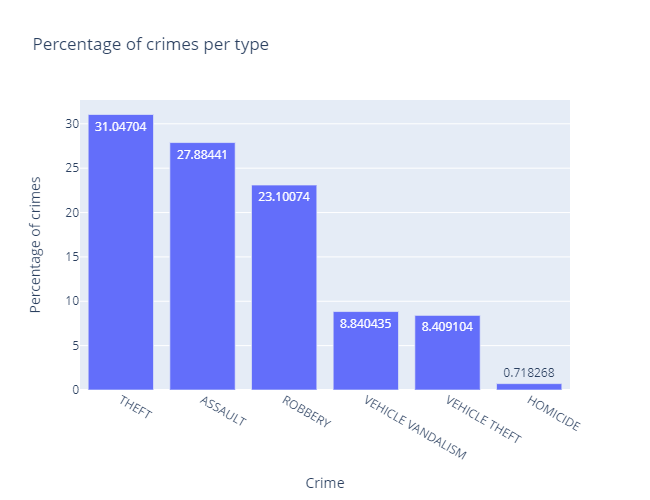

###### Time series

Looking at the crime time series, we see a huge drop in October 2020. This was probably the effect of the restrictive measures introduced to contain the spread of the Covid-19 pandemic.

In [ ]:
# Time series dataframe
ts_costa_rica_crimes = df_costa_rica_crimes.sort_values('Date')
ts_costa_rica_crimes.index = ts_costa_rica_crimes['Date']
ts_costa_rica_crimes.drop('Date', axis=1, inplace=True)

# Choose resample
resample_freq = 'M' # D, M, Y

fig = px.line(
    ts_costa_rica_crimes.groupby(
        'Crime'
    ).resample(resample_freq)['Crime'].size().to_frame("num_crimes").reset_index(),
    x='Date', y="num_crimes", color='Crime',
    labels={"Crime": "Crime", "Date": "Date",
            "num_crimes": "N. of crimes"},
    title=f"Time series of n. of crimes per type"
)

fig.show()

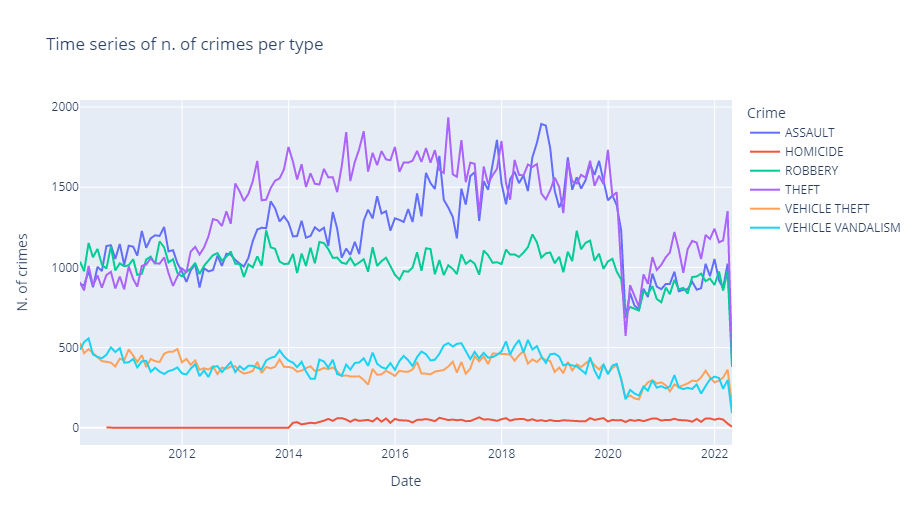

##### Gender of victims

Of the crimes reported, about 63.3% of the victims are male, about 33.7% female and the remaining 3% unknown.

In [17]:
# Number of reported crime per type of crime
df_costa_rica_crimes.groupby(
    "Gender"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

num_crimes
Gender             
male         410106
female       218343
unknown       19777

In [ ]:
# Crimes per gender
df_costa_rica_crimes_by_gender = df_costa_rica_crimes.groupby(
    "Gender"
).size().to_frame("num_crimes"
).sort_values(by='num_crimes', ascending=False)

df_costa_rica_crimes_by_gender.insert(
    loc = df_costa_rica_crimes_by_gender.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_gender.num_crimes.div(
        sum(df_costa_rica_crimes_by_gender.num_crimes)
    ) * 100
)

fig = px.bar(
    df_costa_rica_crimes_by_gender.reset_index(),
    x='Gender', y='perc_crimes', color="Gender",
    labels={"Gender": "Gender", "perc_crimes": "Percentage of crimes"},
    title="Percentage of crimes per gender",
    width=400, height=450, text_auto=True
)
fig.update_layout(showlegend=False)
fig.show()

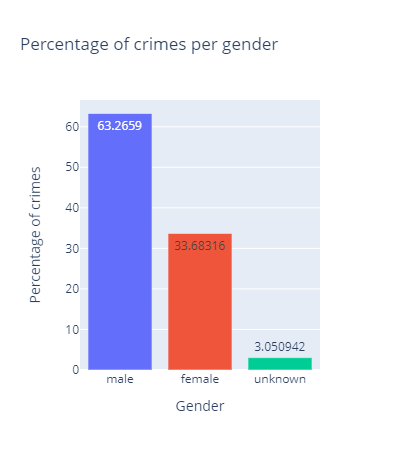

It is interesting to note that the percentage of female victims increases for the most common crimes while the opposite occurs for men

In [ ]:
# Crimes per type
df_costa_rica_crimes_by_type_and_gender = df_costa_rica_crimes.groupby(
    ["Crime", "Gender"]
).size().to_frame("num_crimes")

# Percentage if crimes
df_costa_rica_crimes_by_type_and_gender.insert(
    loc = df_costa_rica_crimes_by_type_and_gender.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_type_and_gender.div(
        df_costa_rica_crimes_by_type_and_gender.groupby(
            'Crime'
        )[['num_crimes']].transform('sum') / 100
    )
)

fig = px.bar(
    df_costa_rica_crimes_by_type_and_gender.reset_index(
    ).sort_values("perc_crimes", ascending=False),
    x='Crime', y='perc_crimes', color="Gender", barmode="group",
    labels={
        "Crime": "Crime",
        "perc_crimes": "Percentage of crimes per type",
        "Gender": "Gender"
    },
    title="Percentage of genders per type of crime",
    width=800, height=500, text_auto=True
)
fig.update_layout(hovermode="x")
fig.show()

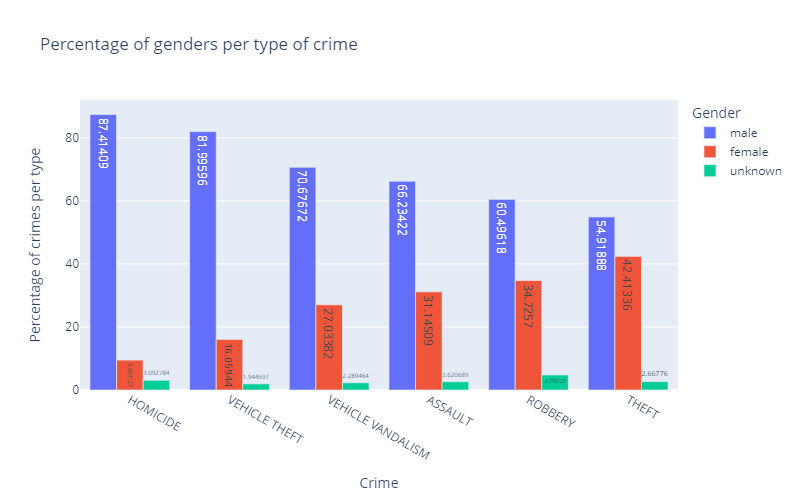

##### Locations of crimes

To geolocalise crimes for spatial analysis purposes we retrieve provinces, cantons and districts by name from the Nominatim API as a GeoDataFrame.

Looking at the distribution of crimes, we see that most were reported around the capital, San José.

###### By province

In [24]:
# Number of reported crime per province
costa_rica_crimes_by_province = df_costa_rica_crimes.groupby(
    "Province"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

costa_rica_crimes_by_province

num_crimes
Province               
SAN JOSE         236525
ALAJUELA         103034
PUNTARENAS        81752
LIMON             63510
HEREDIA           58706
GUANACASTE        54820
CARTAGO           49874
DESCONOCIDO           5

In [50]:
# Number of provinces reporting crimes
print(
    "Number of provinces reporting crimes:",
    costa_rica_crimes_by_province.shape[0]
)

Number of provinces reporting crimes: 8


In [25]:
if not os.path.exists(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_province_boundaries_and_crimes.pickle'
        )
    ):

    # Geocode province boundaries
    df_province_boundaries_and_crimes = pd.DataFrame()
    provinces = sorted(costa_rica_crimes_by_province.index.unique())
    for i, province in enumerate(provinces):
        logging.info(f"Iteration {i} / {len(provinces)}")
        try:
            province_geodata = ox.geocode_to_gdf(f'{province}, Costa Rica')
            logging.info(f"\tgeocoding province {province}")
        except ValueError:
            logging.warning(f"\tgeocoding province {province} failed")
            continue
        province_geodata["province"] = province
        province_geodata["num_crimes"] = costa_rica_crimes_by_province.loc[
                                                province].num_crimes
        df_province_boundaries_and_crimes = pd.concat(
            [df_province_boundaries_and_crimes, province_geodata],
            axis=0, ignore_index=True
        )

    # Save geocoding results with pickle
    with open(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_province_boundaries_and_crimes.pickle'
        ), 'wb') as f:
        pickle.dump(
            df_province_boundaries_and_crimes,
            f,
            protocol=pickle.HIGHEST_PROTOCOL
        )

In [26]:
# Load geocoding data
with open(
        os.path.join(
            dataPath,
            "osm_geocode",
            'df_province_boundaries_and_crimes.pickle'),
        'rb') as f:
    df_province_boundaries_and_crimes = pickle.load(f)

In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        df_province_boundaries_and_crimes,
        lat="lat",
        lon="lon",
        color="province",
        hover_data=["province", "num_crimes"],
        size="num_crimes",
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 6,
            "layers": [
                {
                    "source": json.loads(
                        df_province_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

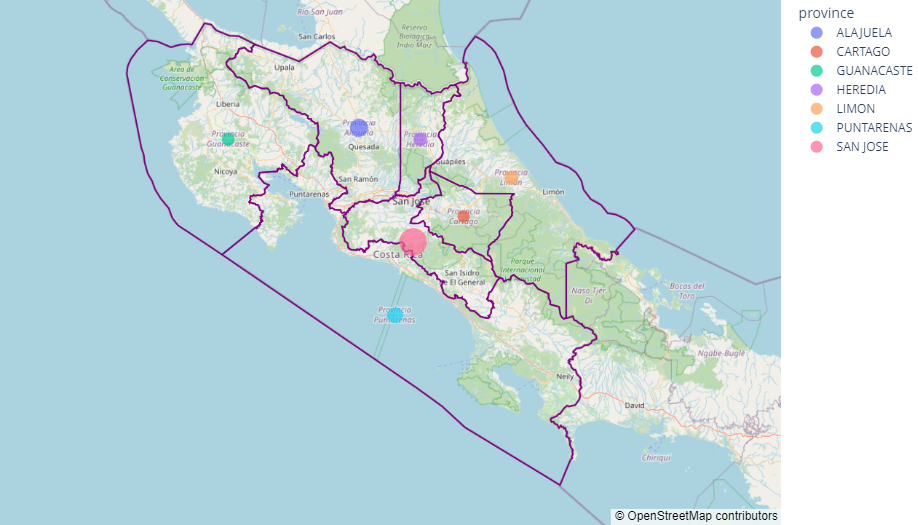

###### By canton

In [28]:
# Number of reported crime per canton
costa_rica_crimes_by_canton = df_costa_rica_crimes.groupby(
    ["Province", "Canton"]
).size().to_frame("num_crimes"
)

# Percentage of crimes
costa_rica_crimes_by_canton.insert(
    loc = costa_rica_crimes_by_canton.shape[1],
    column = "perc_crimes",
    value = costa_rica_crimes_by_canton.div(
        costa_rica_crimes_by_canton.groupby(
            'Province'
        )[['num_crimes']].transform('sum') / 100
    )
)

In [49]:
# Number of cantons reporting crimes
print(
    "Number of cantons reporting crimes:",
    costa_rica_crimes_by_canton.shape[0]
)

Number of cantons reporting crimes: 90


In [30]:
if not os.path.exists(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_canton_boundaries_and_crimes.pickle'
        )
    ):
    
    # Geocode canton boundaries
    df_canton_boundaries_and_crimes = pd.DataFrame()
    provinces_cantons = costa_rica_crimes_by_canton.index.values
    for i, (province, canton) in enumerate(provinces_cantons):
        logging.info(f"Iteration {i} / {len(provinces_cantons)}")
        try:
            canton_geodata = ox.geocode_to_gdf(f'Cantón {canton, province}, Costa Rica')
            logging.info(f"\tgeocoding canton {canton}, province {province}")
        except ValueError:
            logging.warning(f"\tgeocoding canton {canton}, province {province} failed")
            continue

        canton_geodata["province"] = province
        canton_geodata["canton"] = canton
        canton_geodata["num_crimes"] = costa_rica_crimes_by_canton.loc[
                                            (province, canton)].num_crimes
        df_canton_boundaries_and_crimes = pd.concat(
            [df_canton_boundaries_and_crimes, canton_geodata],
            axis=0, ignore_index=True
        )
    
    # Save geocoding results with pickle
    with open(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_canton_boundaries_and_crimes.pickle'
        ), 'wb') as f:
        pickle.dump(
            df_canton_boundaries_and_crimes,
            f,
            protocol=pickle.HIGHEST_PROTOCOL
        )

In [31]:
# Load geocoding data
with open(
        os.path.join(
            dataPath,
            "osm_geocode",
            'df_canton_boundaries_and_crimes.pickle'),
        'rb') as f:
    df_canton_boundaries_and_crimes = pickle.load(f)

In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        df_canton_boundaries_and_crimes,
        lat="lat",
        lon="lon",
        color="province",
        hover_data=["canton", "num_crimes"],
        size="num_crimes",
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 5,
            "layers": [
                {
                    "source": json.loads(
                        df_canton_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1},
                },
                {
                    "source": json.loads(
                        df_province_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

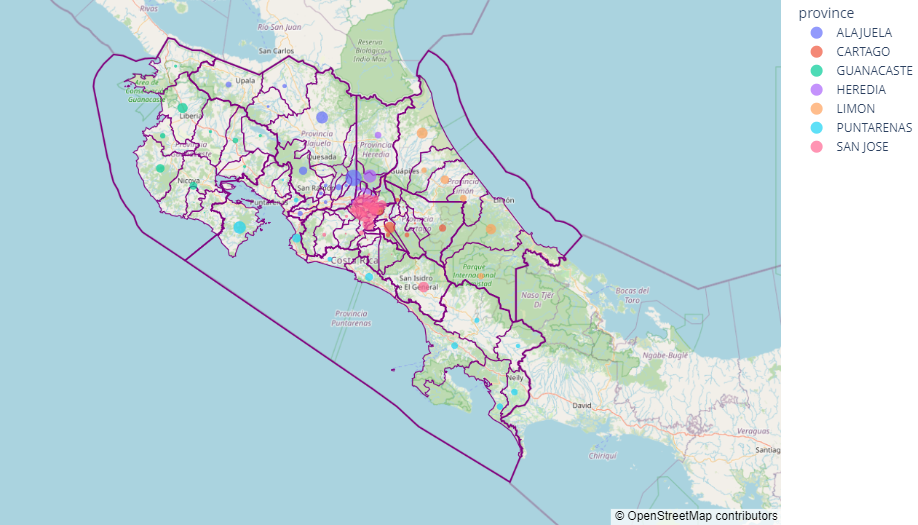

###### By district

In [33]:
# Number of reported crime per district
costa_rica_crimes_by_district = df_costa_rica_crimes.groupby(
    ["Province", "Canton", "District"]
).size().to_frame("num_crimes"
)

# Percentage of crimes
costa_rica_crimes_by_district.insert(
    loc = costa_rica_crimes_by_district.shape[1],
    column = "perc_crimes",
    value = costa_rica_crimes_by_district.div(
        costa_rica_crimes_by_district.groupby(
            ['Province']
        )[['num_crimes']].transform('sum') / 100
    )
)

In [48]:
# Number of districts reporting crimes
print(
    "Number of districts reporting crimes:",
    costa_rica_crimes_by_district.shape[0]
)

Number of districts reporting crimes: 571


In [34]:
if not os.path.exists(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_district_boundaries_and_crimes.pickle'
        )
    ):
    # Geocode district boundaries
    df_district_boundaries_and_crimes = pd.DataFrame()
    provinces_cantons_districts = costa_rica_crimes_by_district.index.values
    for i, (province, canton, district) in enumerate(provinces_cantons_districts):
        logging.info(f"Iteration {i} / {len(provinces_cantons_districts)}")
        try:
            district_geodata = ox.geocode_to_gdf(f'{district}, Cantón {canton}, {province}, Costa Rica')
            logging.info(f"\tgeocoding {district}, canton {canton}, province {province}")
        except ValueError:
            logging.warning(f"\tgeocoding {district}, canton {canton}, province {province} failed")
            continue

        district_geodata["province"] = province
        district_geodata["canton"] = canton
        district_geodata["district"] = district
        district_geodata["num_crimes"] = costa_rica_crimes_by_district.loc[
                                            (province, canton, district)].num_crimes
        df_district_boundaries_and_crimes = pd.concat(
            [df_district_boundaries_and_crimes, district_geodata],
            axis=0, ignore_index=True
        )

    # Save geocoding results with pickle
    with open(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_district_boundaries_and_crimes.pickle'
        ), 'wb') as f:
        pickle.dump(
            df_district_boundaries_and_crimes,
            f,
            protocol=pickle.HIGHEST_PROTOCOL
        )

In [35]:
# Load geocoding data
with open(
        os.path.join(
            dataPath,
            "osm_geocode",
            'df_district_boundaries_and_crimes.pickle'),
        'rb') as f:
    df_district_boundaries_and_crimes = pickle.load(f)

In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        df_district_boundaries_and_crimes,
        lat="lat",
        lon="lon",
        color="province",
        hover_data=["district", "num_crimes"],
        size="num_crimes",
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 6,
            "layers": [
                {
                    "source": json.loads(
                        df_canton_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1},
                },
                {
                    "source": json.loads(
                        df_province_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

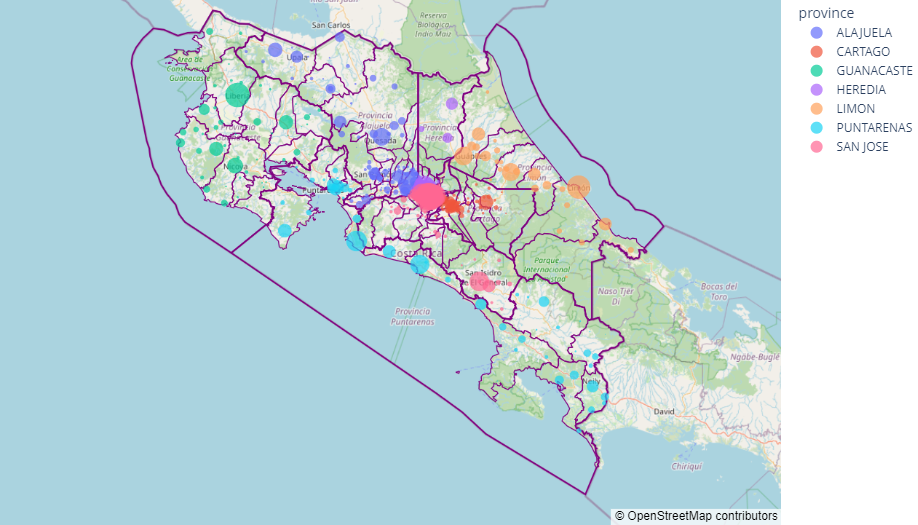

##### Time of the day when crimes occur

To find out how many crimes occur in bright or dark conditions, we map the times to daylight/night.

In [37]:
# Number of reported crime per time of the day
df_costa_rica_crimes.groupby(
    "Time"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

num_crimes
Time                           
00:00:00 - 02:59:59      145059
18:00:00 - 20:59:59      113479
15:00:00 - 17:59:59       82370
12:00:00 - 14:59:59       77992
21:00:00 - 23:59:59       76722
09:00:00 - 11:59:59       67666
06:00:00 - 08:59:59       48238
03:00:00 - 05:59:59       36700

In [38]:
df_costa_rica_crimes.insert(
    loc = df_costa_rica_crimes.columns.get_loc("Time") + 1,
    column = "Daylight-Night",
    value = df_costa_rica_crimes.Time
)
df_costa_rica_crimes.replace(
    {'Daylight-Night': {
        '06:00:00 - 08:59:59': 'daylight',
        '09:00:00 - 11:59:59': 'daylight',
        '12:00:00 - 14:59:59': 'daylight',
        '15:00:00 - 17:59:59': 'daylight',
        '18:00:00 - 20:59:59': 'night',
        '21:00:00 - 23:59:59': 'night',
        '00:00:00 - 02:59:59': 'night',
        '03:00:00 - 05:59:59': 'night'        
    }},
    inplace=True
)

In [39]:
# Number of reported crime per time of the day
df_costa_rica_crimes.groupby(
    "Daylight-Night"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

num_crimes
Daylight-Night            
night               371960
daylight            276266

In [ ]:
# Crimes per time of the day
df_costa_rica_crimes_by_daylight = df_costa_rica_crimes.groupby(
    "Daylight-Night"
).size().to_frame("num_crimes"
).sort_values(by='num_crimes', ascending=False)

df_costa_rica_crimes_by_daylight.insert(
    loc = df_costa_rica_crimes_by_daylight.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_daylight.num_crimes.div(
        sum(df_costa_rica_crimes_by_daylight.num_crimes)
    ) * 100
)

fig = px.bar(
    df_costa_rica_crimes_by_daylight.reset_index(),
    x='Daylight-Night', y='perc_crimes',
    labels={"Daylight-Night": "Night-Daylight", "perc_crimes": "Percentage of crimes"},
    title="Percentage of crimes per daylight / night",
    width=350, height=400, text_auto=True
)
fig.show()

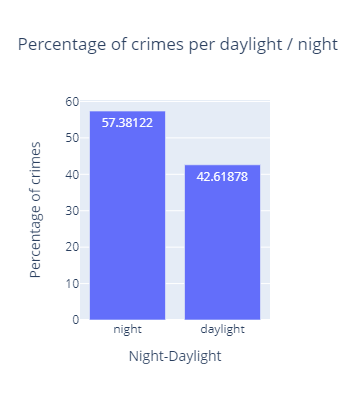

Apart from theft and vehicle vandalism, all other crimes are mostly committed at night.
As reported in several papers, poor lighting conditions are associated with a higher index of danger and crime.

In [ ]:
# Crimes per time of the day
df_costa_rica_crimes_by_type_and_daylight = df_costa_rica_crimes.loc[
    df_costa_rica_crimes.Victim == "PERSON"
].groupby(
    ["Crime", "Daylight-Night"]
).size().to_frame("num_crimes")

# Percentage if crimes
df_costa_rica_crimes_by_type_and_daylight.insert(
    loc = df_costa_rica_crimes_by_type_and_daylight.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_type_and_daylight.div(
        df_costa_rica_crimes_by_type_and_daylight.groupby(
            'Crime'
        )[['num_crimes']].transform('sum') / 100
    )
)

fig = px.bar(
    df_costa_rica_crimes_by_type_and_daylight.reset_index(
    ).sort_values("num_crimes", ascending=False),
    x='Crime', y='perc_crimes', color="Daylight-Night", barmode="group",
    labels={
        "Crime": "Crime",
        "perc_crimes": "Percentage per type",
        "Daylight-Night": "Daylight-Night"
    },
    title="Daylight-Night per type of crime",
    width=800, height=500, text_auto=True
)

fig.update_layout(hovermode="x")
fig.show()

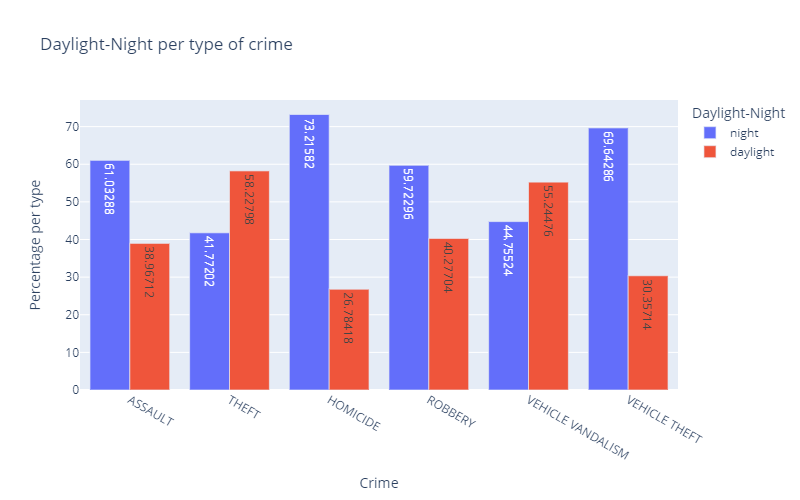

##### Focus on harassment

Since street harassment is a recognised crime in Costa Rica only since August 2020, we have access to data collected in the year 2021.

Beyond this, however, only 42 districts report at least 1 crime of street harassment.

This could always be a consequence of the fact that, as seen above, there was a drop in crime in October 2020, probably related to the restrictive measures for Covid-19.

On the other hand, it still points to a lack of awareness on the part of women to report this crime, which until recently was commonly considered an accepted and legitimate behaviour.

In [44]:
# Read csv as pandas dataframe
df_costa_rica_street_harassement = pd.read_csv(
    os.path.join(
        urbanalyticaDataPath,
        "costa_rica_street_harassement_english.csv"
    )
)

In [45]:
# Harassments by district
costa_rica_street_harassement_by_district = df_costa_rica_street_harassement.drop(
    "public_prosecutors_office", axis=1
).groupby(
        ["province", "canton", "district"]
).sum()

In [47]:
# Number of districts reporting street harassments
print(
    "Number of districts reporting street harassments:",
    costa_rica_street_harassement_by_district.shape[0]
)

Number of districts reporting street harassments: 42


In [51]:
if not os.path.exists(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_district_boundaries_and_harassment.pickle'
        )
    ):
    # Geocode district boundaries
    df_district_boundaries_and_harassment = pd.DataFrame()
    provinces_cantons_districts = costa_rica_street_harassement_by_district.index
    for i, (province, canton, district) in enumerate(provinces_cantons_districts):
        logging.info(f"Iteration {i} / {len(provinces_cantons_districts)}")
        try:
            district_geodata = ox.geocode_to_gdf(f'{district}, Cantón {canton}, {province}, Costa Rica')
            logging.info(f"\tgeocoding {district}, canton {canton}, province {province}")
        except ValueError:
            logging.warning(f"\tgeocoding {district}, canton {canton}, province {province} failed")
            continue

        district_geodata["province"] = province
        district_geodata["canton"] = canton
        district_geodata["district"] = district
        harassment_data = costa_rica_street_harassement_by_district.loc[
            [(province, canton, district)]
        ].reset_index(drop=True)
        district_geodata = pd.concat(
            [district_geodata,harassment_data],
            axis = 1
        )
        df_district_boundaries_and_harassment = pd.concat(
            [df_district_boundaries_and_harassment, district_geodata],
            axis=0, ignore_index=True
        )

    # Save geocoding results with pickle
    with open(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_district_boundaries_and_harassment.pickle'
        ), 'wb') as f:
        pickle.dump(
            df_district_boundaries_and_harassment,
            f,
            protocol=pickle.HIGHEST_PROTOCOL
        )

In [52]:
# Load geocoding data
with open(
        os.path.join(
            dataPath,
            "osm_geocode",
            'df_district_boundaries_and_harassment.pickle'),
        'rb') as f:
    df_district_boundaries_and_harassment = pickle.load(f)

In [ ]:
harassments_list= [
    'sexual_harassement', 'exhibitionism', 'pursuit_or_cornering',
    'production_of_audiovisual_material', 'sexual_harassement_law'
]
df_district_boundaries_and_harassment["num_harassments"] = df_district_boundaries_and_harassment[
    harassments_list].sum(axis=1)

# Scatter map 
fig = (
    px.scatter_mapbox(
        df_district_boundaries_and_harassment,
        lat="lat",
        lon="lon",
        color="province",
        hover_data=["district", "num_harassments"],
        size="num_harassments",
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 6,
            "layers": [
                {
                    "source": json.loads(
                        df_province_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

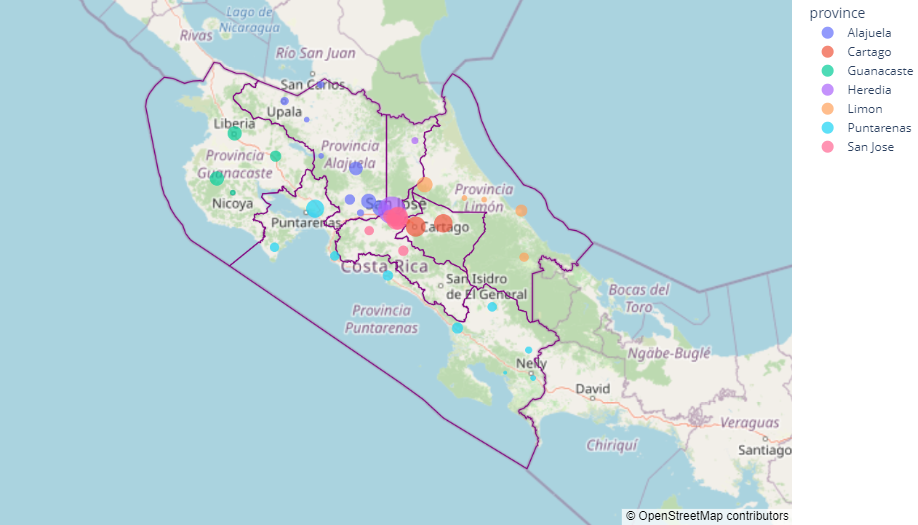

### Crime forecasting

To accomplish the request of predicting the women's security score on a quarterly/annual basis, a Random Forest model was implemented on multiple time series at the district level. In practice, instead of training a different model for each district in Costa Rica (almost 500!), a single Random Forest was trained by concatenating the time series of the districts and using lag and differences in crimes as features.

#### Trimestral by district and type of crime

In [ ]:
province = "SAN JOSE"
canton = "SAN JOSE"
ts_san_jose_crimes_by_trimester_per_type = ts_costa_rica_crimes.loc[
        (ts_costa_rica_crimes.Province==province) &
        (ts_costa_rica_crimes.Canton==canton)
    ].groupby(
        ['Province', 'Canton', 'District', 'Crime']
    ).resample('3M')['Crime'].size().to_frame("num_crimes").reset_index()

ID_District_Crime = ts_san_jose_crimes_by_trimester_per_type.groupby(
    ['District', 'Crime']
).size().reset_index().drop(0, axis=1).reset_index()

ts_san_jose_crimes_by_trimester_per_type = pd.merge(
    ts_san_jose_crimes_by_trimester_per_type,
    ID_District_Crime,
    on = ['District', 'Crime']
).rename(
    columns={
        "Date":'trimester',
        'index': 'ID_District_Crime'
    }
)

In [ ]:
ts_san_jose_crimes_by_trimester_per_type = ts_san_jose_crimes_by_trimester_per_type[
    ['trimester', 'ID_District_Crime', 'num_crimes']
]

In [ ]:
ts_san_jose_crimes_by_trimester_per_type['last_trimester_crimes'] = ts_san_jose_crimes_by_trimester_per_type.groupby(
    ['ID_District_Crime']
)['num_crimes'].shift()
ts_san_jose_crimes_by_trimester_per_type['last_trimester_diff'] = ts_san_jose_crimes_by_trimester_per_type.groupby(
    ['ID_District_Crime']
)['last_trimester_crimes'].diff()
ts_san_jose_crimes_by_trimester_per_type = ts_san_jose_crimes_by_trimester_per_type.dropna()
ts_san_jose_crimes_by_trimester_per_type.head()

trimester  ID_District_Crime  num_crimes  last_trimester_crimes  \
2 2010-07-31                  0          75                   62.0   
3 2010-10-31                  0          61                   75.0   
4 2011-01-31                  0          76                   61.0   
5 2011-04-30                  0          50                   76.0   
6 2011-07-31                  0          54                   50.0   

   last_trimester_diff  
2                 49.0  
3                 13.0  
4                -14.0  
5                 15.0  
6                -26.0

In [ ]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [ ]:
mean_error = []
for trimester in pd.date_range(start='1/1/2018', periods=4*2, freq='3M'):
    train = ts_san_jose_crimes_by_trimester_per_type[
        ts_san_jose_crimes_by_trimester_per_type['trimester'] < trimester
    ]
    val = ts_san_jose_crimes_by_trimester_per_type[
        ts_san_jose_crimes_by_trimester_per_type['trimester'] == trimester
    ]

    p = val['last_trimester_crimes'].values

    error = rmsle(val['num_crimes'].values, p)
    print(f'trimester {trimester}- Error {error:.5f}')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

trimester 2018-01-31 00:00:00- Error 0.46312
trimester 2018-04-30 00:00:00- Error 0.48307
trimester 2018-07-31 00:00:00- Error 0.44226
trimester 2018-10-31 00:00:00- Error 0.48357
trimester 2019-01-31 00:00:00- Error 0.42900
trimester 2019-04-30 00:00:00- Error 0.40426
trimester 2019-07-31 00:00:00- Error 0.35845
trimester 2019-10-31 00:00:00- Error 0.41630
Mean Error = 0.43500


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 300.0)

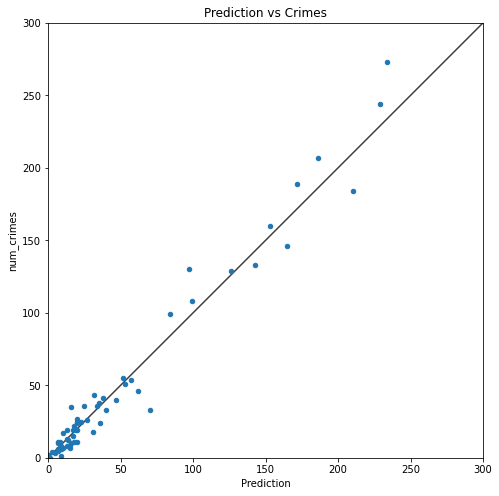

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='num_crimes', title='Prediction vs Crimes', 
                 ylim=(0,300), xlim=(0,300), ax=ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

<AxesSubplot:>

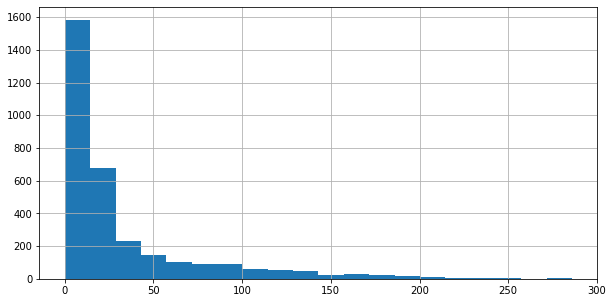

In [ ]:
ts_san_jose_crimes_by_trimester_per_type['num_crimes'].hist(bins=20, figsize=(10,5))

In [ ]:
unique_trimesters = ts_san_jose_crimes_by_trimester_per_type.trimester.unique()
trimester_map = {d: i for i, d in enumerate(unique_trimesters)}
ts_san_jose_crimes_by_trimester_per_type['num_trimester'] = ts_san_jose_crimes_by_trimester_per_type.trimester.map(
    trimester_map)

In [ ]:
ts_san_jose_crimes_by_trimester_per_type.loc[
    ts_san_jose_crimes_by_trimester_per_type.trimester < "2020"]

trimester  ID_District_Crime  num_crimes  last_trimester_crimes  \
2    2010-07-31                  0          75                   62.0   
3    2010-10-31                  0          61                   75.0   
4    2011-01-31                  0          76                   61.0   
5    2011-04-30                  0          50                   76.0   
6    2011-07-31                  0          54                   50.0   
...         ...                ...         ...                    ...   
3324 2018-10-31                 71           5                   10.0   
3325 2019-01-31                 71           6                    5.0   
3326 2019-04-30                 71           4                    6.0   
3327 2019-07-31                 71           9                    4.0   
3328 2019-10-31                 71           6                    9.0   

      last_trimester_diff  num_trimester  
2                    49.0              0  
3                    13.0              1  
4                   -14.0              2  
5                    15.0              3  
6                   -26.0              4  
...                   ...            ...  
3324                -18.0             33  
3325                 -5.0             34  
3326                  1.0             35  
3327                 -2.0             36  
3328                  5.0             37  

[2515 rows x 6 columns]

In [ ]:
mean_error = []
for trimester in range(31, 39):
    train = ts_san_jose_crimes_by_trimester_per_type[
        ts_san_jose_crimes_by_trimester_per_type['num_trimester'] < trimester
    ].drop('trimester', axis=1)
    val = ts_san_jose_crimes_by_trimester_per_type[
        ts_san_jose_crimes_by_trimester_per_type['num_trimester'] == trimester
    ].drop('trimester', axis=1)

    xtr, xts = train.drop(['num_crimes'], axis=1), val.drop(['num_crimes'], axis=1)
    ytr, yts = train['num_crimes'].values, val['num_crimes'].values

    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))

    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print(f'trimester {trimester}- Error {error:.5f}')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

trimester 31- Error 0.48657
trimester 32- Error 0.40203
trimester 33- Error 0.45057
trimester 34- Error 0.43003
trimester 35- Error 0.37367
trimester 36- Error 0.32324
trimester 37- Error 0.38236
trimester 38- Error 0.35607
Mean Error = 0.40057


(0.0, 300.0)

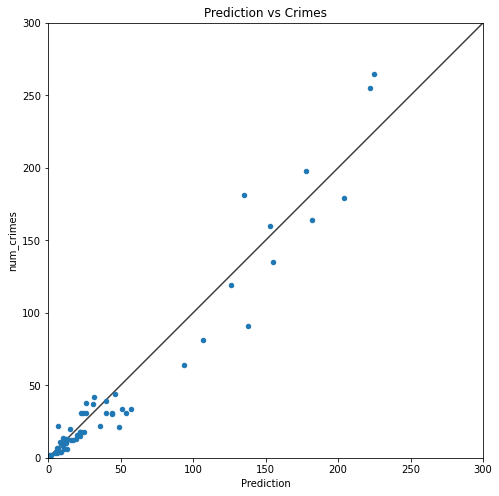

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='num_crimes', title='Prediction vs Crimes', 
                 ylim=(0,300), xlim=(0,300), ax=ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

### Google reviews

We were also provided of two Google reviews datasets regarding parks and public transit areas such as bus stops.

Each record contains the name and geographical coordinates of the place reviewed, as well as a rating from 0 to 5 and possibly a comment left by the user.

We decided to exploit the potentiality of this data by mining negative reviews looking for comments reporting 3 specific aspects:
* poor lighting 
* danger perception
* criminal or illegal acts

We started with some data manipulation.

In [ ]:
# Read park reviews json
with open(os.path.join(googleReviewsDataPath,"google_reviews_parks.json"),'r') as f:
    ds_Reviews_parks = json.load(f)


# extract list of records

records_park = [
    {
        'type' : 'park',
        'address': instance['result']['formatted_address'],
        'lat': instance['result']['geometry']['location']['lat'],
        'lng': instance['result']['geometry']['location']['lng'],
        'name': instance['result']['name'],
        'overall_rating': instance['result']['rating'],
        'text': review['text'].lower(),
        'rating': review['rating']
     } for instance in ds_Reviews_parks['park_reviews'] for review in instance['result'].get('reviews', '')
]



In [ ]:
# Read transit reviews json
with open(os.path.join(googleReviewsDataPath,"google_reviews_transit.json"),'r') as f:
    ds_Reviews_transit = json.load(f)

# extract list of records

records_transit = [
    {
        'type':'transit',
        'address': instance['result']['formatted_address'],
        'lat': instance['result']['geometry']['location']['lat'],
        'lng': instance['result']['geometry']['location']['lng'],
        'name': instance['result']['name'],
        'overall_rating': instance['result']['rating'],
        'text': review['text'].lower(),
        'rating': review['rating']
     } for instance in ds_Reviews_transit['transit_reviews'] for review in instance['result'].get('reviews', '')
]


In [ ]:
# create dataframe from records of reviews

df_reviews = pd.DataFrame.from_records(records_park +  records_transit)

In [ ]:
# bad rated

bad_reviews = df_reviews.loc[df_reviews.rating <=2].text.values

In [ ]:
def string_contain(string, list_of_words):
  for w in list_of_words:
    if w in string:
      return True

  return False

#### Wordcloud of security related negative reviews 
We then exploited NLP processing functions to investigate words frequency in negative reviews. Comments were filtered by specific security and urban related target words (e.g. danger, street, light, assault,...). A wordcloud helped us to visualize and better understand comments content.

In [ ]:
security_target_words = [ 'light', 'street', 'sidewalk', 'pavement',
                'crime', 'security', 'secure', 'violence', 'violent', 'danger', 'risk', 'fear', 'surveillance', 'safe', 'criminality', 'criminal', 'surveilled', 'illegal', 'assault', 'offense', 'robbery','robbed', 'thieves', 'thief', 'theft', 'steal', 'drug',
                'woman', 'women', 'girl',
                'sex']

In [ ]:
bad_reviews_security = [ r for r in bad_reviews if string_contain(r, security_target_words)]

len(bad_reviews_security)

67

In [ ]:
# process reviews removing stop words and punctuation

bad_reviews_security_tokenized = [ [word for word in word_tokenize(r) if (not word in stopwords.words() and not word in list(string.punctuation))]
for r in bad_reviews_security]


In [ ]:
# flat list 
bad_reviews_security_tokenized_flat = [item for sublist in bad_reviews_security_tokenized for item in sublist]


In [ ]:
# count frequencies

def count_word_freq(list_of_words):     
  unique_word = []
  freq = []

  # loop till string values present in list 
  for i in list_of_words:    
    # checking for the duplicacy
    if i not in unique_word:

        # insert value in str2
        unique_word.append(i) 
            
  for i in range(0, len(unique_word)):
    # count the frequency of each word
    freq.append(list_of_words.count(unique_word[i]))    
  
  df_freq = pd.DataFrame(unique_word, columns = ['word'])
  df_freq['frequency'] = freq

  return df_freq

In [ ]:
bad_reviews_security_word_freq = count_word_freq(bad_reviews_security_tokenized_flat)
bad_reviews_security_word_freq.sort_values(by = 'frequency', ascending = False, inplace = True)

In [ ]:
# function for wordcloud in image

def makeImagefromDFfreq(df,image,nwords,maxfont, bg_color = "white"):
    #this function create a colored word cloud given the image background, 
    #the dataframe with words and frequencies, the maximum number of words to 
    #represent in the image and the maximum font to be used
    
    otherstopword=[]

    #build a dictionary of frequency from the dataframe
    freqdict = {}
    for a, x in df.values:
        if a not in otherstopword: 
            if not np.isnan(x):
                freqdict[a] = float(x)
            
    # read the mask / color image taken from
    mask = np.array(Image.open(image))
    
    #generate wordcloud using frequency
    wordcloud_R = WordCloud( background_color= bg_color, mode="RGBA", max_font_size=maxfont,max_words=nwords, mask=mask).generate_from_frequencies(freqdict)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[20,20])
    plt.imshow(wordcloud_R.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    # store to file
    #plt.savefig(os.path.join(dataPath,"wordcloud img/wordcloud.png"))

    #plot image
    plt.show()
 
       

In [ ]:
#create wordcloud image

makeImagefromDFfreq(bad_reviews_security_word_freq.loc[bad_reviews_security_word_freq.word.isin(['...', "n't", "'s", "bus", 'stop' 'even', 'us', 'many', 'san']) == False,:],
                    os.path.join(dataPath,"wordcloud img/wcloud_back3.png"),1440, 1440)


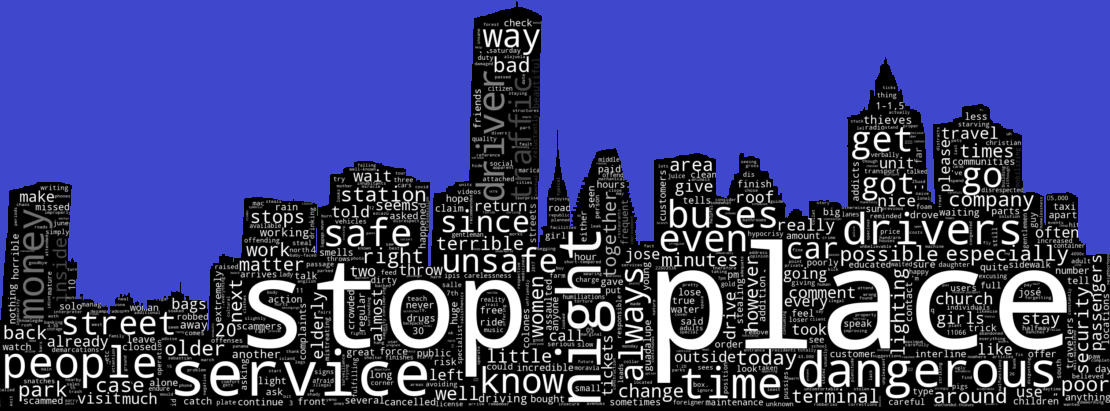

We surprisingly discovered that many users reported security perception and poor urban conditions in reviews,allowing us to obtain various statistics on the aspects in question, to be used later in the definition of the women's safety index


Some interesting examples:

* *'it has no lighting, it looks dangerous at night'*
* *'the place is very beautiful, but they assaulted me there'*
* *'the park is beautiful but they are young in apparent drug use'*
* *'not a safe place to go. not clean at all. very crowded. full of ilegal sales like drugs, medicines and stolen phones'*
* *'much improvement has to be made in security and lighting, there is nowhere to sit'* 
* *'an unsafe place at night'*



In [ ]:
# add columns indicating type of bad review

df_reviews['Poor_lighting'] = [0]*df_reviews.shape[0]
df_reviews['Feel_unsafe'] = [0]*df_reviews.shape[0]
df_reviews['Report_crime'] = [0]*df_reviews.shape[0]

df_reviews.loc[(df_reviews.rating <=2) & df_reviews.text.map(lambda r: string_contain(r, 
                                                                                      ['lighting','no light', 'poor light'])), 'Poor_lighting'] = 1

df_reviews.loc[(df_reviews.rating <=2) & df_reviews.text.map(lambda r: string_contain(r, 
                                                                                       [ 'crime', 'violence', 'violent', 'criminality', 'criminal', 'surveilled', 'illegal', 'assault', 'offense', 'robbery','robbed', 'thieves', 'thief', 'theft', 'steal', 'drug'])), 'Report_crime'] = 1

df_reviews.loc[(df_reviews.rating <=2) & df_reviews.text.map(lambda r: string_contain(r, 
                                                                                      ['security', 'secure', 'danger', 'risk', 'fear', 'surveillance', 'safe', 'surveilled'])), 'Feel_unsafe'] = 1

#### Locations of negative reviews

In [ ]:
if not os.path.exists(
        os.path.join(
            dataPath,
            'osm_geocode',
            'df_district_boundaries_and_reviews.pickle')):

  # create geocode data for reviews

  df_district_boundaries_and_reviews = df_district_boundaries_and_crimes.copy(deep=True)
  df_district_boundaries_and_reviews.drop('num_crimes', axis = 1,  inplace = True)

  # count reviews per district

  num_reviews = [0]*df_district_boundaries_and_reviews.shape[0]
  num_bad_reviews	= [0]*df_district_boundaries_and_reviews.shape[0]
  num_poor_lighting_reviews	= [0]*df_district_boundaries_and_reviews.shape[0]
  num_feel_unsafe_reviews	= [0]*df_district_boundaries_and_reviews.shape[0]
  num_report_crime_reviews = [0]*df_district_boundaries_and_reviews.shape[0]

  for i in range(df_reviews.shape[0]):
    point = Point(df_reviews.iloc[i].lng, df_reviews.iloc[i].lat)

    rating	= df_reviews.iloc[i].rating
    Poor_lighting	= df_reviews.iloc[i].Poor_lighting
    Feel_unsafe	= df_reviews.iloc[i].Feel_unsafe
    Report_crime = df_reviews.iloc[i].Report_crime

    for j in range(df_district_boundaries_and_reviews.shape[0]):
      polygon = df_district_boundaries_and_reviews.iloc[j].geometry
      if polygon.contains(point):
        num_reviews[j] = num_reviews[j] + 1

        if rating <=2:
          num_bad_reviews[j] = num_bad_reviews[j] + 1

          if Poor_lighting:
            num_poor_lighting_reviews[j] = num_poor_lighting_reviews[j] + 1

          if Feel_unsafe:
            num_feel_unsafe_reviews[j] = num_feel_unsafe_reviews[j] + 1

          if Report_crime:
            num_report_crime_reviews[j] = num_report_crime_reviews[j] + 1

        break 

  df_district_boundaries_and_reviews['num_reviews'] = num_reviews
  df_district_boundaries_and_reviews['num_bad_reviews'] = num_bad_reviews
  df_district_boundaries_and_reviews['num_poor_lighting_reviews'] = num_poor_lighting_reviews
  df_district_boundaries_and_reviews['num_feel_unsafe_reviews'] = num_feel_unsafe_reviews
  df_district_boundaries_and_reviews['num_report_crime_reviews'] = num_report_crime_reviews


  # Save geocoding results with pickle
  with open(
      os.path.join(
          dataPath,
          'osm_geocode',
          'df_district_boundaries_and_reviews.pickle'
      ), 'wb') as f:
      pickle.dump(
          df_district_boundaries_and_reviews,
          f,
          protocol=pickle.HIGHEST_PROTOCOL
      )

In [ ]:
# Load geocoding data
with open(
        os.path.join(
            dataPath,
            "osm_geocode",
            'df_district_boundaries_and_reviews.pickle'),
        'rb') as f:
    df_district_boundaries_and_reviews = pickle.load(f)



In [ ]:
# compute percentages of bad reviews (for district with at list one)

df_district_boundaries_and_reviewed = df_district_boundaries_and_reviews.loc[df_district_boundaries_and_reviews.num_reviews>0]
df_district_boundaries_and_reviewed['perc_bad_reviews'] = 100 * df_district_boundaries_and_reviews['num_bad_reviews']/df_district_boundaries_and_reviews['num_reviews']
df_district_boundaries_and_reviewed['perc_poor_lighting_reviews'] = 100 * df_district_boundaries_and_reviews['num_poor_lighting_reviews']/df_district_boundaries_and_reviews['num_reviews']
df_district_boundaries_and_reviewed['perc_feel_unsafe_reviews'] = 100 * df_district_boundaries_and_reviews['num_feel_unsafe_reviews']/df_district_boundaries_and_reviews['num_reviews']
df_district_boundaries_and_reviewed['perc_report_crime_reviews'] = 100 * df_district_boundaries_and_reviews['num_report_crime_reviews']/df_district_boundaries_and_reviews['num_reviews']

Finally we plotted the geographical distribution of bad reviews percentage in Costa Rica. 

In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        df_district_boundaries_and_reviewed,
        lat="lat",
        lon="lon",
        color="province",
        hover_data=["district", "perc_bad_reviews"], # perc_feel_unsafe_reviews
        size="perc_bad_reviews", # perc_feel_unsafe_reviews
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 6,
            "layers": [
                {
                    "source": json.loads(
                        df_canton_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1},
                },
                {
                    "source": json.loads(
                        df_province_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

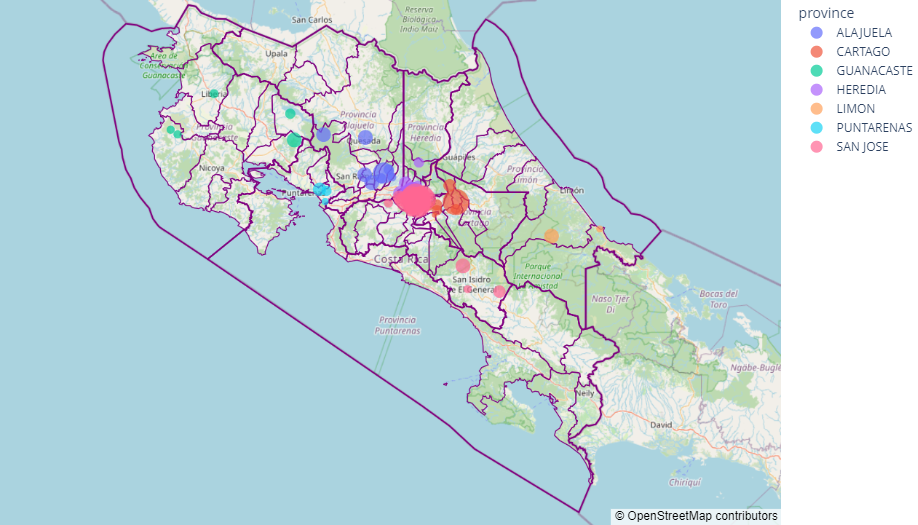

### Street lighting

Street lighting is generally not guaranteed in Costa Rica. Many studies, as well as several comments from our reviews sample, highlight how the scarce presence of street lamps contributes to the insecurity of a place, increasing the risk of passing pedestrians.

For this reason we have dedicated a good part of our resources to the research of georeferenced data regarding street lighting. Unfortunately there are no specific repositories for most of the countries of the world. We therefore relied on the public data provided by OpenStreetMap.

Costa Rica .osm file is available on [Geofabrik service](https://download.geofabrik.de/central-america/costa-rica.html).


#### Extract street lighting from OSM








In [OSM Wiki](https://wiki.openstreetmap.org/wiki/Tag:highway%3Dstreet_lamp) several node and way tags are defined to report lighting conditions. We scanned all Costa Rica OSM elements to obtain street lighting statistics at district level.

In [ ]:
osm_wayDataPath = os.path.join(
    dataPath, 'osm_costa_rica_ways'
)

In [ ]:
if not os.path.exists(
        os.path.join(osm_wayDataPath, 'costa_rica_ways.pickle')):

  class WayHandler(osmium.SimpleHandler):
      def __init__(self):
          super(WayHandler, self).__init__()
          self.lighted_ways = []
          self.not_lighted_ways = []
          self.all_nodes_to_locate = []


      def way(self, w): 
        w_nodes = []
        w_nodes = [node.ref for node in w.nodes]
        elements_of_interest = (w.id, w_nodes)
        self.all_nodes_to_locate+=[w_nodes[0], w_nodes[-1]] # save start and end nodes, to match location after
        
        
        if w.tags.get('lit') == 'yes':
          self.lighted_ways.append(elements_of_interest)
          
        else:
          self.not_lighted_ways.append(elements_of_interest)
          
          
          
  class NodeHandler(osmium.SimpleHandler):
      def __init__(self, list_of_nodes):
          super(NodeHandler, self).__init__()
          self.list_of_nodes = list_of_nodes
          self.list_of_nodes_with_info = []

      def node(self, n): 
              if n.id in self.list_of_nodes: 
                  self.list_of_nodes_with_info.append((n.id, n.location.lon, n.location.lat))
        
          
    
  src_filepath = os.path.join(osm_wayDataPath,"costa-rica-latest.osm.pbf")

  way_handler = WayHandler()
  way_handler.apply_file(src_filepath)

  lighted_ways = way_handler.lighted_ways
  not_lighted_ways = way_handler.not_lighted_ways
  all_nodes_to_locate = list(set(way_handler.all_nodes_to_locate))

  print(len(lighted_ways), len(not_lighted_ways))

  node_handler = NodeHandler(all_nodes_to_locate)
  node_handler.apply_file(src_filepath)


  # dataframe with way starting and ending node location
  way_extreme_nodes = pd.DataFrame.from_records(node_handler.list_of_nodes_with_info, columns=['node_id', 'longitude', 'latitude'])   


  # create dataframe of costa rica ways
  way_records = []

  for w in lighted_ways:
      w_id = w[0]
      w_nodes = w[1]
      
      w_start_id = w_nodes[0]
      w_end_id = w_nodes[-1]
      w_start_location = way_extreme_nodes.loc[way_extreme_nodes.node_id == w_start_id, ['longitude', 'latitude']].values[0]
      w_end_location = way_extreme_nodes.loc[way_extreme_nodes.node_id == w_end_id, ['longitude', 'latitude']].values[0]
      
      w_length_km = geopy.distance.geodesic(w_start_location, w_end_location).km
      
      w_light = 'yes'
      
      way_records.append((w_id, w_nodes, w_start_id, w_start_location, w_end_id, w_end_location, w_length_km, w_light))


  for w in not_lighted_ways:
      w_id = w[0]
      w_nodes = w[1]
      
      w_start_id = w_nodes[0]
      w_end_id = w_nodes[-1]
      w_start_location = way_extreme_nodes.loc[way_extreme_nodes.node_id == w_start_id, ['longitude', 'latitude']].values[0]
      w_end_location = way_extreme_nodes.loc[way_extreme_nodes.node_id == w_end_id, ['longitude', 'latitude']].values[0]
      
      w_length_km = geopy.distance.geodesic(w_start_location, w_end_location).km
      
      w_light = 'no'
      
      way_records.append((w_id, w_nodes, w_start_id, w_start_location, w_end_id, w_end_location, w_length_km, w_light))


  costa_rica_ways = pd.DataFrame.from_records(way_records, columns=['w_id', 'w_nodes', 'w_start_id', 'w_start_location', 'w_end_id', 'w_end_location', 'w_length_km', 'w_light'])   

  with open(os.path.join(osm_wayDataPath,'costa_rica_ways.pickle'), 'wb') as f:
          pickle.dump(
              costa_rica_ways,
              f,
              protocol=pickle.HIGHEST_PROTOCOL
          )




#### Statistics by district

Here we computed the percentage of ways/street kms with lamps and then visualize the rate distribution on the map. 

In [ ]:
if not os.path.exists(
        os.path.join(osm_wayDataPath, 'district_way_stast.pickle')):

  with open(os.path.join(osm_wayDataPath, 'costa_rica_ways.pickle'), "rb") as input_file:
    costa_rica_ways = pickle5.load(input_file)


  # obtain ways and street light statistics by district 
  # assign ways to districts (note: if a way stars and ends in different districts, the way is assigned to both districts)
  df_district_boundaries_and_street_lights = df_district_boundaries_and_crimes.copy(deep=True)
  df_district_boundaries_and_street_lights.drop('num_crimes', axis = 1,  inplace = True)

  num_ways = [0]*df_district_boundaries_and_street_lights.shape[0]
  num_ways_with_light	= [0]*df_district_boundaries_and_street_lights.shape[0]
  total_km_ways	= [0]*df_district_boundaries_and_street_lights.shape[0]
  total_km_ways_with_light	= [0]*df_district_boundaries_and_street_lights.shape[0]


  for i in range(costa_rica_ways.shape[0]):
    coord_start = costa_rica_ways.iloc[i].w_start_location
    coord_end = costa_rica_ways.iloc[i].w_end_location
    start_point = Point(coord_start[0], coord_start[1])
    end_point = Point(coord_end[0], coord_end[1])
                      
    way_length = costa_rica_ways.iloc[i].w_length_km	
    way_light = costa_rica_ways.iloc[i].w_light

    for j in range(df_district_boundaries_and_street_lights.shape[0]):
      polygon = df_district_boundaries_and_street_lights.iloc[j].geometry
      if polygon.contains(start_point) or polygon.contains(end_point):
        num_ways[j] = num_ways[j] + 1
        total_km_ways[j] = total_km_ways[j] + way_length

        if way_light == 'yes':
          num_ways_with_light[j] = num_ways_with_light[j] + 1
          total_km_ways_with_light[j] = total_km_ways_with_light[j] + way_length

        break 

  df_district_boundaries_and_street_lights['num_ways'] = num_ways
  df_district_boundaries_and_street_lights['num_ways_with_light'] = num_ways_with_light
  df_district_boundaries_and_street_lights['total_km_ways'] = total_km_ways
  df_district_boundaries_and_street_lights['total_km_ways_with_light'] = total_km_ways_with_light


  with open(os.path.join(osm_wayDataPath, 'district_way_stast.pickle'), 'wb') as f:
          pickle.dump(
              df_district_boundaries_and_street_lights,
              f,
              protocol=pickle.HIGHEST_PROTOCOL
          )


In [ ]:
with open(
        os.path.join(osm_wayDataPath, 'district_way_stast.pickle'),
        'rb') as f:
    df_district_boundaries_and_street_lights = pickle.load(f)


df_district_boundaries_and_street_lights['perc_ways_with_light'] = 100 * df_district_boundaries_and_street_lights['num_ways_with_light']/(df_district_boundaries_and_street_lights['num_ways'] + 0.000001)
df_district_boundaries_and_street_lights['perc_km_ways_with_light'] = 100 * df_district_boundaries_and_street_lights['total_km_ways_with_light']/(df_district_boundaries_and_street_lights['total_km_ways'] + 0.000001)


In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        df_district_boundaries_and_street_lights,
        lat="lat",
        lon="lon",
        color="province",
        hover_data=["district", "perc_ways_with_light"], # perc_km_ways_with_light
        size="perc_ways_with_light",
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 6,
            "layers": [
                {
                    "source": json.loads(
                        df_canton_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1},
                },
                {
                    "source": json.loads(
                        df_province_boundaries_and_crimes.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

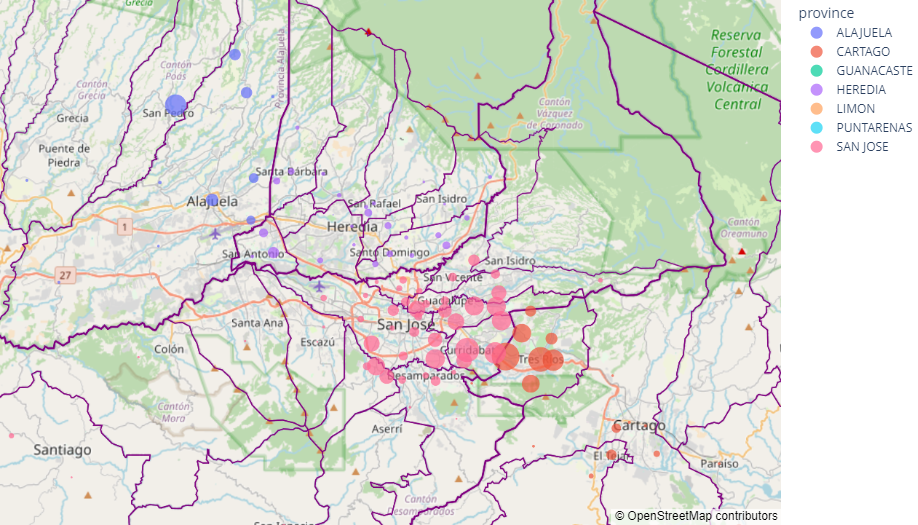

### Districts' urban design and crimes

We also decided to take into account the urban structure of the considered districts to investigate whether it has an inpact on crime rates.

For this purpose, we now download their corresponding OSM graphs, with the goal of extracting meaningful summary metrics that can be included as input in the prediction models and in the what-if analysis.

In [ ]:
if not os.path.exists(
        os.path.join(
            dataPath,
            'dict_districts_graphs.pickle'
        )
    ):
    %%time
    dict_districts_graphs = {}
    provinces_cantons_districts = costa_rica_crimes_by_district.index.values

    for i, (province, canton, district) in enumerate(provinces_cantons_districts):
        logging.info(f"Iteration {i} / {len(provinces_cantons_districts)}")
        try:
            G = ox.graph_from_place(f'{district}, Cantón {canton}, {province}, Costa Rica')
            G_projected = ox.project_graph(G)
            logging.info(f"\tGraph obtained for {district}, canton {canton}, province {province}")
            dict_districts_graphs[(province, canton, district)] = G_projected
        except ValueError:
            logging.warning(f"\t{district}, canton {canton}, province {province} not found")
        except:
            logging.warning(f"\tEmpty graph found for {district}, canton {canton}, province {province}")
            continue
    
    # Save graph results with pickle
    with open(
        os.path.join(
            dataPath,
            'dict_districts_graphs.pickle'
        ), 'wb') as f:
        pickle.dump(
            dict_districts_graphs,
            f,
            protocol=pickle.HIGHEST_PROTOCOL
        )

In [ ]:
# Load graphs associated to each district from pickle
with open(
        os.path.join(
            dataPath,
            'dict_districts_graphs.pickle'),
        'rb') as f:
    dict_districts_graphs = pickle.load(f)

Below, you can see an example of the extracted graphs.

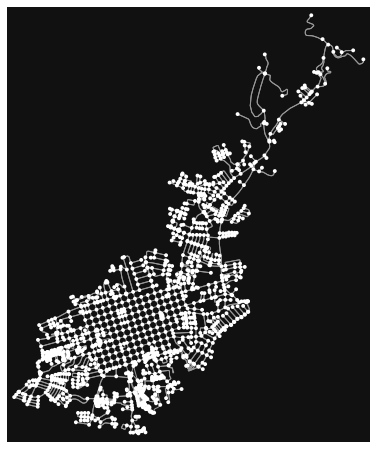

In [ ]:
# Print an example district graph
G_example = list(dict_districts_graphs.values())[0]
fig, ax = ox.plot_graph(G_example)

In [ ]:
# Expand graph via Depth-First Search
%%time
nodes_proj, edges_proj = ox.graph_to_gdfs(
    G_example, nodes=True, edges=True)

CPU times: user 297 ms, sys: 2.92 ms, total: 300 ms
Wall time: 331 ms


As you can see below, we started focusing on statistics at a node level.

In [ ]:
%%time
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(G_example, area=area)
print(stats)

{'n': 1488, 'm': 3402, 'k_avg': 4.57258064516129, 'edge_length_total': 239657.06900000063, 'edge_length_avg': 70.44593445032352, 'streets_per_node_avg': 2.7076612903225805, 'streets_per_node_counts': {0: 0, 1: 342, 2: 15, 3: 869, 4: 260, 5: 2}, 'streets_per_node_proportions': {0: 0.0, 1: 0.22983870967741934, 2: 0.010080645161290322, 3: 0.584005376344086, 4: 0.17473118279569894, 5: 0.0013440860215053765}, 'intersection_count': 1146, 'street_length_total': 139664.90900000004, 'street_segment_count': 1999, 'street_length_avg': 69.86738819409707, 'circuity_avg': 1.0733244892291338, 'self_loop_proportion': 0.00400200100050025, 'node_density_km': 122.31181637229098, 'intersection_density_km': 94.19982631898216, 'edge_density_km': 19699.523800974155, 'street_density_km': 11480.288107030063}
CPU times: user 1.3 s, sys: 25 ms, total: 1.33 s
Wall time: 2.08 s


In [ ]:
%%time
extended_stats = ox.extended_stats(G_example, ecc=True, cc=True)
series = pd.Series(extended_stats)
series

In [ ]:
stats_columns = [
    'avg_neighbor_degree', 
    'degree_centrality', 
    'clustering_coefficient', 
    'pagerank', 
    'eccentricity', 
    'closeness_centrality'
]

series_list = [pd.Series(extended_stats[column_name], name=column_name).sort_index()
               for column_name in stats_columns]
series_list.append(nodes_proj['geometry'].sort_index())

gdf_stats = pd.concat(series_list, axis=1)

gdf_stats = gpd.GeoDataFrame(
    gdf_stats, geometry="geometry", crs=nodes_proj.crs)
gdf_stats.head(5)

avg_neighbor_degree  degree_centrality  clustering_coefficient  \
275730899                  2.0           0.002690                0.166667   
275730900                  3.0           0.002017                0.333333   
276045277                  3.0           0.002690                0.000000   
276045280                  3.0           0.005380                0.000000   
276045281                  3.0           0.004035                0.000000   

           pagerank  eccentricity  closeness_centrality  \
275730899  0.000498      7180.767              0.000499   
275730900  0.000680      7071.964              0.000480   
276045277  0.000660      7399.834              0.000398   
276045280  0.001055      6742.557              0.000497   
276045281  0.001119      5882.453              0.000556   

                                 geometry  
275730899  POINT (805537.289 1107852.304)  
275730900  POINT (805565.282 1107956.949)  
276045277  POINT (804219.749 1108540.667)  
276045280  POINT (804822.424 1108802.233)  
276045281  POINT (805650.508 1109039.353)

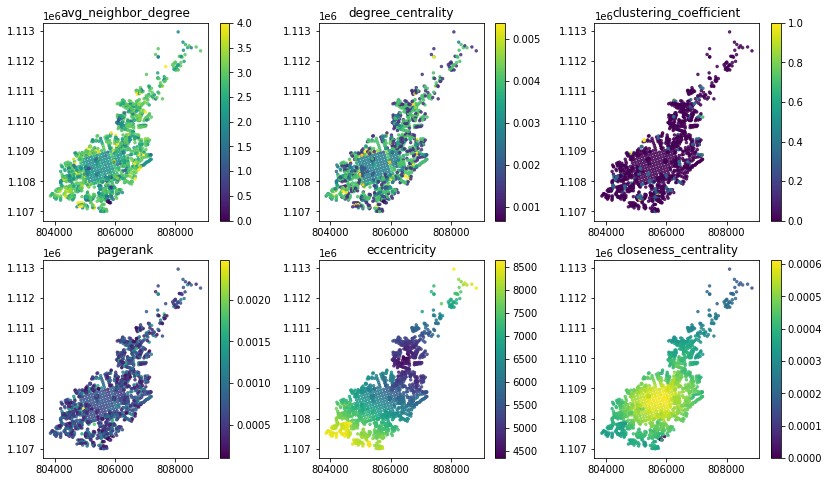

In [ ]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats.plot(ax=ax, column=column_name, legend=True, s=6, alpha=0.8)
    ax.set_title(column_name)

We soon realized that aggregating this kind of information to obtain an overall description of the whole graphs would have resulted in a huge loss of detail.

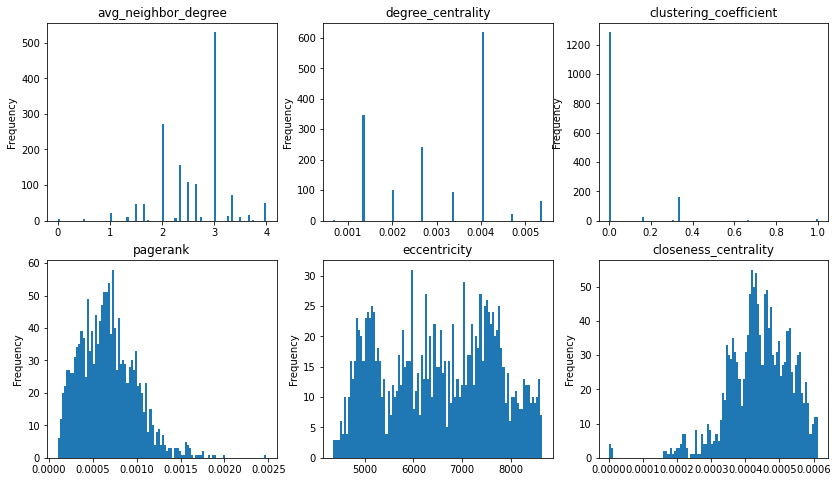

In [ ]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats[column_name].plot(ax=ax, kind='hist', bins=100)
    ax.set_title(column_name)

In [ ]:
# Calculate advanced statistics for the example graph
%%time
extended_stats = ox.extended_stats(G_example, ecc=True, cc=True)
series = pd.Series(extended_stats)
series

/usr/local/lib/python3.7/dist-packages/osmnx/stats.py:458: UserWarning:

The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.



CPU times: user 36 s, sys: 163 ms, total: 36.2 s
Wall time: 40.9 s


For this reason, we finally extracted the graphs' density as a measure of the level of interconnection which characterizes each district.

In [ ]:
# Compute summary metrics for the districts' graphs to setup the what-if analysis
districts_densities = {k: nx.density(v) for k, v in dict_districts_graphs.items()}

### Regression

After obtaining and analyzing possible various safety-related factors, we test and quantify their association and predictive capacity with
* a simple and multilevel Linear Regressor (developed in R) 
* a ```sklearn``` Random Forest model 
jointly exploiting the better interpretability ability of the former and better performances in the latter.

In this way, we aim to define a data-driven Women Safety Index which requires little effort to be estimated.


#### Create unique dataset

Start merging all available features at district level:
* crimes 
* socio economic factors (year 2017)
* population (year 2017)
* google reviews
* street lighting
* urban network

In [ ]:
# Load geocoding data with population
with open(
        os.path.join(
            dataPath,
            "osm_geocode",
            'df_district_boundaries_and_population.pickle'),
        'rb') as f:
    df_district_boundaries_and_population = pickle.load(f)

In [ ]:
# load socio-economical district data 2017

district_data = pd.read_csv(
    os.path.join(
        urbanalyticaDataPath,
        "district_data.csv"
    ),
    index_col=0
)

# manipulate province, canton, district for subsequent merge
provinces = []
canton = []
districts = []


for pcd in district_data['{Provincia, Canton, Distrito}'].values:
  p,c,d = [s[1:-1] for s in pcd[1:-1].split(', ')]
  provinces.append(p)
  canton.append(c)
  districts.append(d)

district_data['province'] = provinces
district_data['canton'] = canton
district_data['district'] = districts

In [ ]:
# merge

merged = pd.merge(df_district_boundaries_and_crimes, df_district_boundaries_and_reviews, on=['geometry', 'bbox_north', 'bbox_south', 'bbox_east', 'bbox_west',
       'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'display_name', 'class',
       'type', 'importance', 'province', 'canton', 'district'])

merged = pd.merge(merged, df_district_boundaries_and_street_lights, on=['geometry', 'bbox_north', 'bbox_south', 'bbox_east', 'bbox_west',
       'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'display_name', 'class',
       'type', 'importance', 'province', 'canton', 'district'])


merged = pd.merge(merged, df_district_boundaries_and_population.loc[:,['osm_id', 'Total 2011',
       'Total 2012', 'Total 2013', 'Total 2014', 'Total 2015', 'Total 2016',
       'Total 2017', 'Total 2018', 'Total 2019', 'Total 2020', 'Total 2021',
       'Total 2022', 'Total 2023', 'Total 2024', 'Total 2025', 'Males 2011',
       'Males 2012', 'Males 2013', 'Males 2014', 'Males 2015', 'Males 2016',
       'Males 2017', 'Males 2018', 'Males 2019', 'Males 2020', 'Males 2021',
       'Males 2022', 'Males 2023', 'Males 2024', 'Males 2025', 'Females 2011',
       'Females 2012', 'Females 2013', 'Females 2014', 'Females 2015',
       'Females 2016', 'Females 2017', 'Females 2018', 'Females 2019',
       'Females 2020', 'Females 2021', 'Females 2022', 'Females 2023',
       'Females 2024', 'Females 2025']], on='osm_id')

merged = pd.merge(merged, district_data, on = ['province', 'canton', 'district']) 

merged.shape


(431, 98)

In [ ]:
df_district = merged.loc[:, ['province', 'canton', 'district', 'num_crimes',
       'num_reviews', 'num_bad_reviews', 'num_poor_lighting_reviews',
       'num_feel_unsafe_reviews', 'num_report_crime_reviews', 'num_ways',
       'num_ways_with_light', 'total_km_ways', 'total_km_ways_with_light',
       'perc_ways_with_light', 'perc_km_ways_with_light', 'Total 2011',
       'Total 2012', 'Total 2013', 'Total 2014', 'Total 2015', 'Total 2016',
       'Total 2017', 'Total 2018', 'Total 2019', 'Total 2020', 'Total 2021',
       'Total 2022', 'Total 2023', 'Total 2024', 'Total 2025', 'Males 2011',
       'Males 2012', 'Males 2013', 'Males 2014', 'Males 2015', 'Males 2016',
       'Males 2017', 'Males 2018', 'Males 2019', 'Males 2020', 'Males 2021',
       'Males 2022', 'Males 2023', 'Males 2024', 'Males 2025', 'Females 2011',
       'Females 2012', 'Females 2013', 'Females 2014', 'Females 2015',
       'Females 2016', 'Females 2017', 'Females 2018', 'Females 2019',
       'Females 2020', 'Females 2021', 'Females 2022', 'Females 2023',
       'Females 2024', 'Females 2025', 'PCD', '{Provincia, Canton, Distrito}',
       'Tasa de Asaltos por cada 10 mil habitantes',
       'Tasa de Homicidios dolosos por cada 10 mil habitantes',
       'Tasa de Hurtos por cada 10 mil habitantes',
       'Tasa de Robos por cada 10 mil habitantes',
       'Tasa de Robo de vehículos por cada 10 mil habitantes',
       'Tasa de Violaciones por cada 10 mil habitantes', 'Económica',
       'Participación electoral', 'Salud', 'Educación', 'Seguridad',
       'IDS 2017', 'Población total', 'Densidad de población',
       'Porcentaje población urbana', 'Relación hombres mujeres',
       'Relación dependencia demográfica',
       'Porcentaje de población de 65 años y más',
       'Porcentaje de población nacida en el extranjero',
       'Porcentaje de personas unidas o casadas', 'Porcentaje de discapacidad',
       'Porcentaje de población no asegurada']]

In [ ]:
# define rate of total crimes by district

df_district['sum_rate'] = df_district[[
       'Tasa de Asaltos por cada 10 mil habitantes',
       'Tasa de Homicidios dolosos por cada 10 mil habitantes',
       'Tasa de Hurtos por cada 10 mil habitantes',
       'Tasa de Robos por cada 10 mil habitantes',
       'Tasa de Robo de vehículos por cada 10 mil habitantes',
       'Tasa de Violaciones por cada 10 mil habitantes']].sum(axis = 1)

In [ ]:
# obtain reviews stats percentages

df_district['perc_bad_reviews'] = 100 * df_district['num_bad_reviews']/(df_district['num_reviews'] + 0.001)
df_district['perc_poor_lighting_reviews'] = 100 * df_district['num_poor_lighting_reviews']/(df_district['num_reviews'] + 0.001)
df_district['perc_feel_unsafe_reviews'] = 100 * df_district['num_feel_unsafe_reviews']/(df_district['num_reviews'] + 0.001)
df_district['perc_report_crime_reviews'] = 100 * df_district['num_report_crime_reviews']/(df_district['num_reviews'] + 0.001)


In [ ]:
# select only useful columns

df_district_sub = df_district.loc[:, ['province', 'canton', 'district', 'sum_rate',
       'perc_bad_reviews', 'perc_poor_lighting_reviews', 'perc_feel_unsafe_reviews', 'perc_report_crime_reviews',
       'perc_ways_with_light', 'perc_km_ways_with_light',  
       'Total 2017','Económica',
       'Participación electoral', 'Salud', 'Educación', 'Seguridad',
       'IDS 2017', 'Densidad de población',
       'Porcentaje población urbana', 'Relación hombres mujeres',
       'Relación dependencia demográfica',
       'Porcentaje de población de 65 años y más',
       'Porcentaje de población nacida en el extranjero',
       'Porcentaje de personas unidas o casadas', 'Porcentaje de discapacidad',
       'Porcentaje de población no asegurada']]

In [ ]:
# Encode missing values in a proper way
df_district_sub['Porcentaje de población de 65 años y más'].replace('*', np.NaN, inplace = True)
df_district_sub['Porcentaje de población de 65 años y más'] = df_district_sub['Porcentaje de población de 65 años y más'].astype(float) 

In [ ]:
# Add column containing the density of the graph associated with each district
df_district_sub["District's graph density"] = df_district_sub.apply(lambda x:
                                                                    districts_densities.get((x['province'],x['canton'],x['district']), np.NaN), axis=1)

In [ ]:
# Count and drop rows containing NaN values
df_district_sub.isna().any(axis=1).describe()
df_district_sub.dropna(inplace=True)

#### R Linear Regressor

In [ ]:
# load R env and pass dataset
%load_ext rpy2.ipython
%R -i df_district_sub # import data from Python to R

In [ ]:
%%R
# simple linear regression
reg = lm(sum_rate ~ . -province -canton -district,  data = df_district_sub)
summary(reg)


Call:
lm(formula = sum_rate ~ . - province - canton - district, data = df_district_sub)

Residuals:
    Min      1Q  Median      3Q     Max 
-372.74  -44.85   -0.73   36.12 1326.14 

Coefficients:
                                                    Estimate Std. Error t value
(Intercept)                                       -1.779e+04  3.660e+04  -0.486
perc_bad_reviews                                   1.147e+00  7.319e-01   1.568
perc_poor_lighting_reviews                        -9.728e+00  1.252e+01  -0.777
perc_feel_unsafe_reviews                          -4.592e+00  3.414e+00  -1.345
perc_report_crime_reviews                         -4.689e+00  6.092e+00  -0.770
perc_ways_with_light                              -1.358e+00  4.219e+00  -0.322
perc_km_ways_with_light                           -4.080e-01  2.222e+00  -0.184
`Total 2017`                                      -4.016e-04  6.296e-04  -0.638
Económica                                          3.398e+02  6.662e+02   0.510
`P

In [ ]:
%%R
# multilevel linear regression - Province level
install.packages('lme4')
install.packages('lmerTest')
library(lme4)
library(lmerTest)

reg_ml = lmer(sum_rate ~ . -province -canton -district + (1 |province),  data = df_district_sub)
summary(reg_ml)

# no big differences

2022-05-23 22:21:56,899 | WARNING : R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

2022-05-23 22:21:58,321 | WARNING : R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lme4_1.1-29.tar.gz'

2022-05-23 22:21:58,466 | WARNING : R[write to console]: Content type 'application/x-gzip'
2022-05-23 22:21:58,472 | WARNING : R[write to console]:  length 3306026 bytes (3.2 MB)

2022-05-23 22:21:58,476 | WARNING : R[write to console]: =
2022-05-23 22:21:58,488 | WARNING : R[write to console]: =
2022-05-23 22:21:58,496 | WARNING : R[write to console]: =
2022-05-23 22:21:58,500 | WARNING : R[write to console]: =
2022-05-23 22:21:58,507 | WARNING : R[write to console]: =
2022-05-23 22:21:58,511 | WARNING : R[write to console]: =
2022-05-23 22:21:58,514 | WARNING : R[write to console]: =
2022-05-23 22:21:58,518 | WARNING : R[write to console]: =
2022-05-23 22:21:58,522 | WARNING : R[write to console]: =
2022-05-23 22:21:58,52

#### `sklearn` Tree based regressors

In [ ]:
# define function to evaluate model performance

def regr_fit_print_test_scores(regr, X_train, y_train, X_test, y_test):

    # final fit and testing
    regr = regr.fit(X_train, y_train)

    # test model 
    print('-------------------- TRAIN SCORES -------------------')
    predictions = np.maximum(regr.predict(X_train), np.zeros(regr.predict(X_train).shape))
    print("%0.3f Mean Squared Error" % (mean_squared_error(predictions, y_train)))  
    print("%0.3f Root Mean Squared Error" % (np.sqrt(mean_squared_error(predictions, y_train))))  
    print("%0.3f Mean Absolute Error" % (mean_absolute_error(predictions, y_train)))
    
    print('-------------------- TEST SCORES ---------------------')
    predictions = np.maximum(regr.predict(X_test), np.zeros(regr.predict(X_test).shape))
    print("%0.3f Mean Squared Error" % (mean_squared_error(predictions, y_test)))  
    print("%0.3f Root Mean Squared Error" % (np.sqrt(mean_squared_error(predictions, y_test))))  
    print("%0.3f Mean Absolute Error" % (mean_absolute_error(predictions, y_test)))

    fig, ax = plt.subplots(figsize=(10,8))

    plt.scatter(predictions, y_test)
    ax.set_title('Crime rate')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Real')
    plt.plot(y_test, y_test, color = 'red')

    plt.show()

  
    return regr

In [ ]:
# one hot encode province
df_district_sub = df_district_sub.join(pd.get_dummies(df_district_sub['province'], prefix='province', drop_first=True))

In [ ]:
# predictors
X = df_district_sub.drop(['canton', 'district', 'sum_rate'], axis=1, inplace=False)

# target
y = df_district_sub['sum_rate']

# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify = X['province'])

X_train = X_train.iloc[:, 1:-6] # use [:, 1:] to add province info
X_test = X_test.iloc[:, 1:-6] # use [:, 1:] to add province info

##### Decision tree

In [ ]:
# define model
regr = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)

In [ ]:
# Hyper parameters range intialization for tuning 
parameters_tree_CV = {"max_depth": list(range(6,16,2)),
            "min_samples_leaf": list(range(4,10))
            }

In [ ]:
# Perform Grid Search Cross Validation to find the best model
tuning_model = GridSearchCV(regr,
                            param_grid=parameters_tree_CV,
                            scoring='neg_mean_squared_error',
                            cv=5)
tuning_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [6, 8, 10, 12, 14],
                         'min_samples_leaf': [4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [ ]:
# Show GS CV results
tuning_model.best_params_

{'max_depth': 6, 'min_samples_leaf': 8}

-------------------- TRAIN SCORES -------------------
11974.708 Mean Squared Error
109.429 Root Mean Squared Error
37.566 Mean Absolute Error
-------------------- TEST SCORES ---------------------
13170.696 Mean Squared Error
114.764 Root Mean Squared Error
52.243 Mean Absolute Error


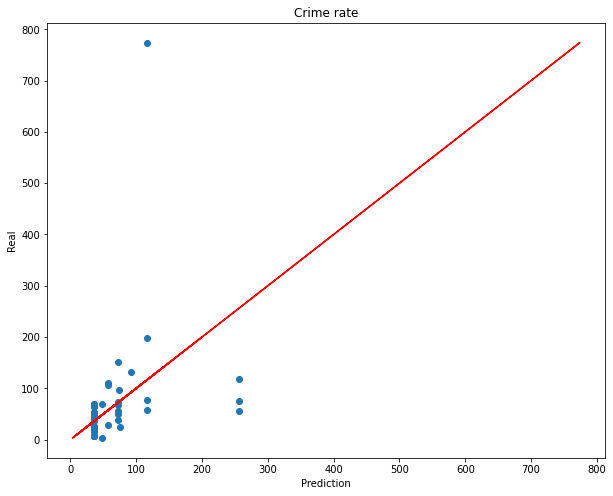

In [ ]:
# Fit and evaluate model with the best parameters
# define model
regr = DecisionTreeRegressor(random_state=0, max_depth=6, min_samples_leaf=8).fit(X_train, y_train)
regr = regr_fit_print_test_scores(regr, X_train, y_train, X_test, y_test)

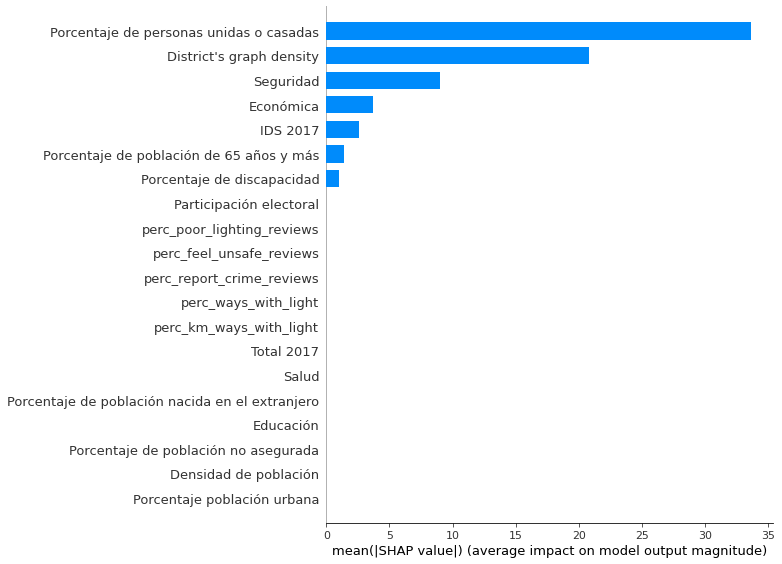

In [ ]:
# interpret with shap
shap_values = shap.TreeExplainer(regr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = X_train.columns, plot_type="bar")

##### Random Forest

-------------------- TRAIN SCORES -------------------
5910.856 Mean Squared Error
76.882 Root Mean Squared Error
24.146 Mean Absolute Error
-------------------- TEST SCORES ---------------------
7530.808 Mean Squared Error
86.780 Root Mean Squared Error
37.366 Mean Absolute Error


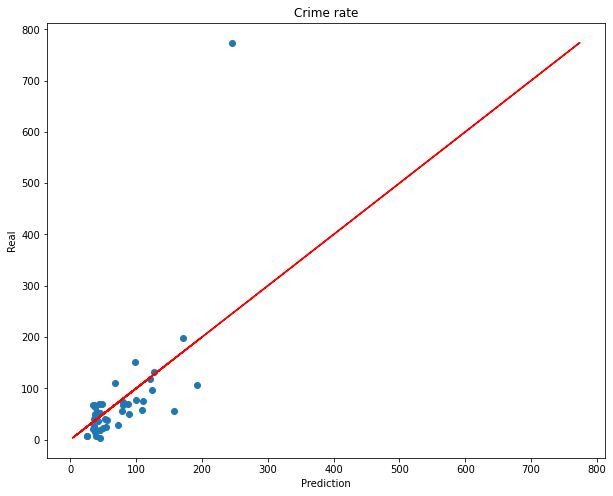

In [ ]:
# define model
n_estimators = 100
max_depth = 10
min_samples_split = 4
min_samples_leaf = 2
max_features = 'log2' #None


regr = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, max_features = max_features).fit(X_train, y_train)

# fit and evaluate model
regr = regr_fit_print_test_scores(regr, X_train, y_train, X_test, y_test)

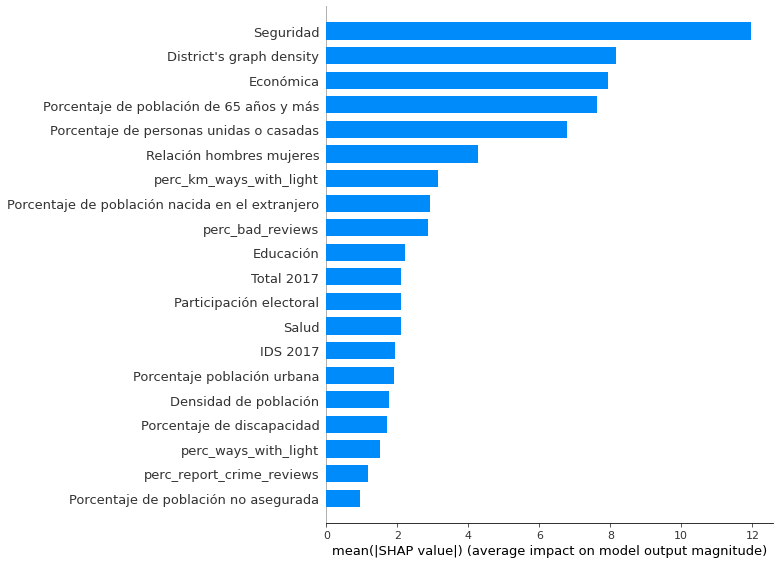

In [ ]:
# interpret with shap
shap_values = shap.TreeExplainer(regr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = X_train.columns, plot_type="bar")

### Conclusions and future directions

After a detailed EDA on the available data and an heavy pre-processing work,regression models, i.e. Linear, regression tree and Random Forest models, have been employed to uncover the impact of external factors on criminality.
The models have been fed with socio-economic indexes, data on street lighting, perception of danger from reviews, and the structure of the urban network (graph density).

After the crime rate prediction at a district level, SHAP features importance techniques are also exploited to draw the final conclusions.

The advantage of using linear regression is that we can define the security index as a simple linear combination of external factors. However, since the linearity assumptions for the model are not met, the estimations are not reliable.

On the other hand, by combining the Random Forest model with SHAPley Additive exPlanations, we obtain a more accurate and at the same time still interpretable prediction.

As it can be seen in the above results, our regression models confirmed the association between criminality and population factors already proved by other works.

A relevant finding is the positive association of crime rate with the perception of danger, extracted from reviews.

On the other hand, street lighting revealed to be not significant, probably as a consequence of the limited lighting data reported.

Another meaningful insight regards the graph density impact: the level of interconnection which characterizes each district in positively correlated with the safety index: in other words, an higher probability of finding isolated streets determines an higher crimes rate.


From the models, it is now immediate to extract a "what-if" tool policy makers can use to test and quantify how different urban planning solutions impact on women security, answering to questions such as "What if we increase the number of street lamps in Carmen district in the province and canton of San José?"

## 👓 References

* Safe Cities and Safe Public Spaces: Global results report: https://www.unwomen.org/en/digital-library/publications/2017/10/safe-cities-and-safe-public-spaces-global-results-report
* Red Dot Foundation: https://reddotfoundation.org/
* Street lighting papers:
    * https://link.springer.com/article/10.1007/s10940-020-09490-6
    * https://www.sciencedirect.com/science/article/pii/S0198971516304240
* Configuration of the street network paper: https://link.springer.com/article/10.1007/s10940-016-9306-9
* Spatial features in urban environments paper: https://crimesciencejournal.biomedcentral.com/articles/10.1186/s40163-020-0012
* Analysis of violence against women in Costa Rica in 2020: https://infosegura.org/en/2021/06/18/violence-against-women-costa-rica-2020/
* Challenge provider goals: https://urbanalytica.org/
* Challenge data: https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip
* Demographic data: https://www.inec.cr/

## ⏭️ Appendix


### Crime data further analysis

##### Age of victims

As for the age of the victims, we see that most of the victims are aged over 18 and before 60. However, given the unequal size of the age ranges considered and the lack of population data by age, it is difficult to interpret this fact.

In [ ]:
# Number of reported crime per type of crime
df_costa_rica_crimes.groupby(
    "Age"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

num_crimes
Age                 
>18 y/o       559971
< 18 y/o       33335
> 60 y/o       31269
unknown        23651

In [ ]:
# Crimes per age
df_costa_rica_crimes_by_age = df_costa_rica_crimes.groupby(
    "Age"
).size().to_frame("num_crimes"
).sort_values(by='num_crimes', ascending=False)

df_costa_rica_crimes_by_age.insert(
    loc = df_costa_rica_crimes_by_age.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_age.num_crimes.div(
        sum(df_costa_rica_crimes_by_age.num_crimes)
    ) * 100
)

fig = px.bar(
    df_costa_rica_crimes_by_age.reset_index(),
    x='Age', y='perc_crimes', color="Age",
    labels={"Age": "Age", "perc_crimes": "Percentage of crimes"},
    title="Percentage of crimes per age",
    width=400, height=450, text_auto=True
)
fig.update_layout(showlegend=False)
fig.show()

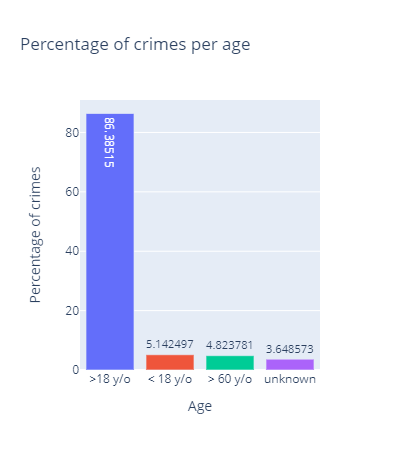

In [ ]:
# Crimes per type
df_costa_rica_crimes_by_type_and_age = df_costa_rica_crimes.groupby(
    ["Crime", "Age"]
).size().to_frame("num_crimes")

# Percentage if crimes
df_costa_rica_crimes_by_type_and_age.insert(
    loc = df_costa_rica_crimes_by_type_and_age.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_type_and_age.div(
        df_costa_rica_crimes_by_type_and_age.groupby(
            'Crime'
        )[['num_crimes']].transform('sum') / 100
    )
)

fig = px.bar(
    df_costa_rica_crimes_by_type_and_age.reset_index(
    ).sort_values("num_crimes", ascending=False),
    x='Crime', y='perc_crimes', color="Age", barmode="group",
    labels={
        "Crime": "Crime",
        "perc_crimes": "Percentage per type",
        "Age": "Age"
    },
    title="Age of victims per type of crime",
    width=800, height=500, text_auto=True
)

fig.update_layout(hovermode="x")
fig.show()

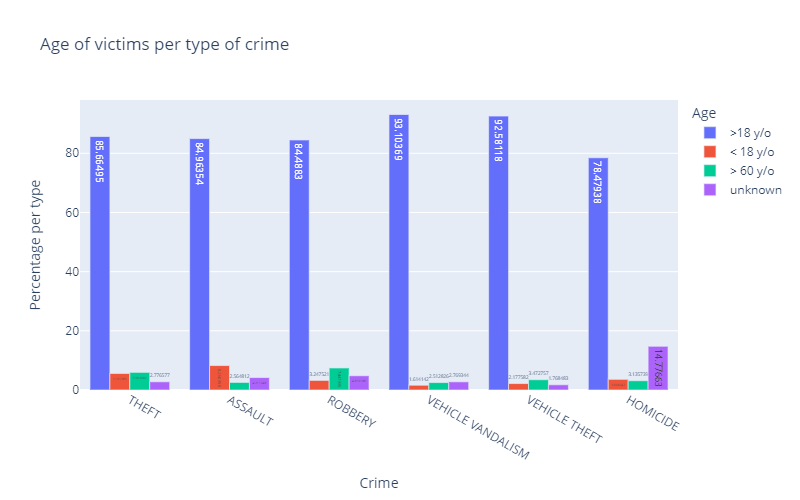

And the percentages remain similar also when separating between male and female victims

In [ ]:
# Crimes per gender and age
df_costa_rica_crimes_by_gender_and_age = df_costa_rica_crimes.groupby(
    ["Gender", "Age"]
).size().to_frame("num_crimes")

# Percentage if crimes
df_costa_rica_crimes_by_gender_and_age.insert(
    loc = df_costa_rica_crimes_by_gender_and_age.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_gender_and_age.div(
        df_costa_rica_crimes_by_gender_and_age.groupby(
            'Gender'
        )[['num_crimes']].transform('sum') / 100
    )
)

fig = px.bar(
    df_costa_rica_crimes_by_gender_and_age.reset_index(
    ).sort_values("perc_crimes", ascending=False),
    x='Gender', y='perc_crimes', color="Age", barmode="group",
    labels={
        "Gender": "Gender",
        "perc_crimes": "Percentage per gender",
        "Age": "Age"
    },
    title="Age per gender of the victims",
    width=800, height=500, text_auto=True
)
fig.update_layout(hovermode="x")
fig.show()

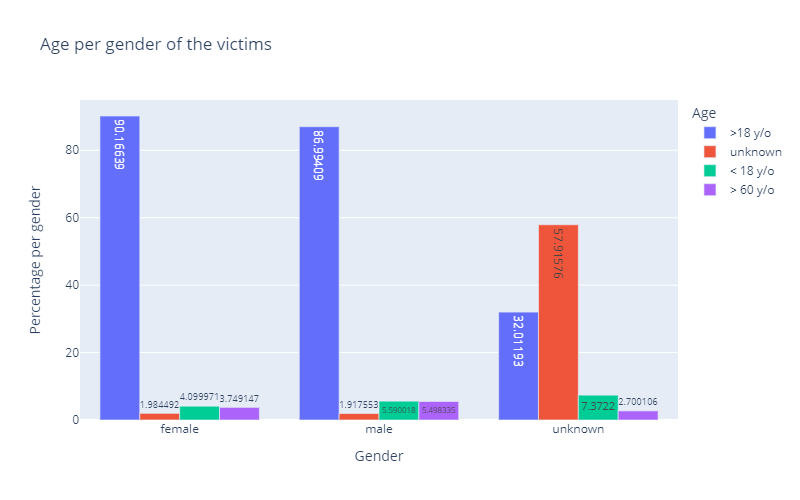

##### Type of victim

In more than 38% of the crimes reported, the crime victim is a person

In [ ]:
df_costa_rica_crimes.insert(
    loc = df_costa_rica_crimes.columns.get_loc("SubtypeVictim"),
    column = "Victim",
    value = df_costa_rica_crimes.SubtypeVictim.apply(
        lambda s: s.split("[")[1][:-1]
    )
)
df_costa_rica_crimes.replace(
    {'Victim': {
        'BULDING': 'BUILDING',
        'OTHER': 'OTHERS',
        'VEHICULE': 'VEHICLE',
        'VEHICULO': 'VEHICLE'        
    }},
    inplace=True
)

In [ ]:
# Number of reported crime per type of victim
costa_rica_crimes_by_victim = df_costa_rica_crimes.groupby(
    "Victim"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)
costa_rica_crimes_by_victim

num_crimes
Victim              
PERSON        248042
VEHICLE       142085
HOUSING       136436
BUILDING       93488
OTHERS         28175

In [ ]:
# Crimes per victim bar plot
df_costa_rica_crimes_by_victim = df_costa_rica_crimes.groupby(
    "Victim"
).size().to_frame("num_crimes"
).sort_values(by='num_crimes', ascending=False)

df_costa_rica_crimes_by_victim.insert(
    loc = df_costa_rica_crimes_by_victim.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_victim.num_crimes.div(
        sum(df_costa_rica_crimes_by_victim.num_crimes)
    ) * 100
)

fig = px.bar(
    df_costa_rica_crimes_by_victim.reset_index(),
    x='Victim', y='perc_crimes', color="Victim",
    labels={"Victim": "Victim", "perc_crimes": "Percentage of crimes"},
    title="Percentage of crimes per type of victim",
    width=400, height=450, text_auto=True
)
fig.update_layout(showlegend=False)
fig.show()

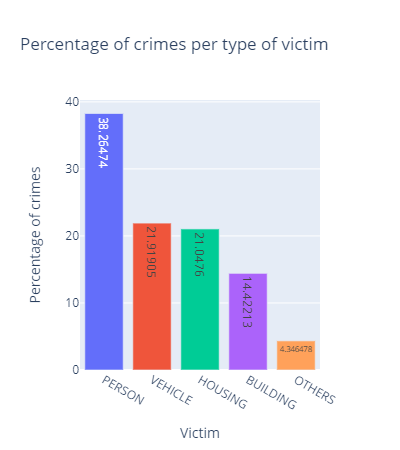

##### Nationality of victim

In [ ]:
# Number of reported crime per victim's nationality
df_costa_rica_crimes.loc[
    df_costa_rica_crimes.Victim=="PERSON"          
].groupby(
    "Nationality"
).size().to_frame("num_crimes"
).sort_values("num_crimes", ascending=False)

num_crimes
Nationality                         
COSTA RICA                    194564
NICARAGUA                      25198
Desconocido                     8846
ESTADOS UNIDOS                  4006
ALEMANIA                        1370
...                              ...
REINO UNIDO                        1
REPUBLICA CENTROAFRICANA           1
CAIMAN, ISLAS                      1
RUANDA                             1
ZAMBIA                             1

[143 rows x 1 columns]

In [ ]:
# Crimes per nationality
df_costa_rica_crimes_by_nationality = df_costa_rica_crimes.loc[
    df_costa_rica_crimes.Victim == "PERSON"
].groupby(
    "Nationality"
).size().to_frame("num_crimes"
).sort_values(by='num_crimes', ascending=False)

df_costa_rica_crimes_by_nationality.insert(
    loc = df_costa_rica_crimes_by_nationality.shape[1],
    column = "perc_crimes",
    value = df_costa_rica_crimes_by_nationality.num_crimes.div(
        sum(df_costa_rica_crimes_by_nationality.num_crimes)
    ) * 100
)

fig = px.bar(
    df_costa_rica_crimes_by_nationality.reset_index().head(5),
    x='Nationality', y='perc_crimes', color="Nationality",
    labels={"Nationality": "Nationality", "perc_crimes": "Percentage of crimes"},
    title="Percentage of crimes per nationality",
    width=600, height=450, text_auto=True
)
fig.update_layout(showlegend=False)
fig.show()

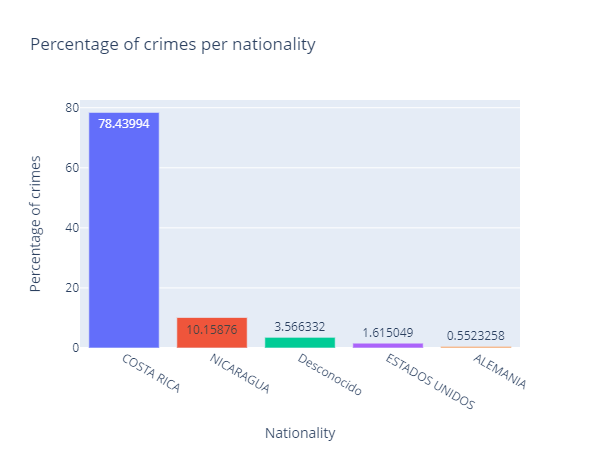

### Multilevel regression

In [ ]:
%%R
# multilevel linear regression - Province level
install.packages('lme4')
install.packages('lmerTest')
library(lme4)
library(lmerTest)

reg_ml = lmer(sum_rate ~ . -province -canton -district + (1 |province),  data = df_district_sub)
summary(reg_ml)

# no big differences